# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [219]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats
import sklearn
from datetime import datetime
from decimal import Decimal

import pymrmr

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [324]:
# Easier to read column names - Convention is different for older datasets
frame_columns = ('X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Epoch Time')
std_columns =   ('X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time')
data_columns =  ('X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro')

# Columns not currently used for classification - Usually for phone data
unused_columns = ('LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)',
                  'MagX', 'MagY', 'MagZ')

'''Get columns for given label'''
def get_columns(_label):
    columns = []
    
    # New naming scheme
    if 'Phone' in _label or 'Wheel' in _label or 'Module' in _label:
        columns = std_columns.copy()
    # Old frame data naming scheme
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [327]:
# Types of terrain tested and placements on the wheelchair
terrains = ('Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel')
placements = ('Left', 'Right', 'Middle')
transforms = ('FFT', 'PSDLog', 'PSD')

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_paths = glob.glob('imu_data/set_full/*.csv')

In [5]:
# Import datasets as an array of Pandas DataFrames
TRIM_START = 2400 # Number of data points to trim from each side (1s = 200 data points)
TRIM_END = 2600
TRIM_OFFSET = 200 # Difference between startup of wheels and frame (1s)
N_DATA_COL = 6 # Number of columns containing directional data

dataset_labels = []

for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split(' ')[-1].split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    for to_remove in unused_columns:
        if to_remove in dataset.columns:
            dataset = dataset.drop(to_remove, axis=1)

    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f",))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Frame and Middle Phone data
    ## Can't remove from wheel-mounted devices because they rotate over time
    if 'Middle' in dataset_label:
        # Calculate gravity from last 2000 datapoints and subtract from Z Zccel
        ## We need to calculate it manually because device may not be exactly parallel to terrain
        #g_z = dataset.loc[-2000:]['Z Accel'].mean()

        # Using direct 9.81 instead if we assume calibrated to flat surface
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Trim edges to account for start and end time of 10 s plus some offest
    # Wheels start up about 1 s after the frame module
    if 'Middle' in dataset_label:
        dataset = dataset[TRIM_START + TRIM_OFFSET : -TRIM_END]
    else:
        dataset = dataset[TRIM_START : -TRIM_END]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# List all datasets
dataset_labels

['Left_AsphaltStraight2_Module',
 'Middle_CarpetPowerDonut_Module',
 'Right_AsphaltDonut_Module',
 'Left_Asphalt_Module',
 'Middle_SidewalkDonut_Module',
 'Middle_AsphaltPowerDonut_Module',
 'Right_GravelStraight_Module',
 'Left_ConcreteStraight2_Module',
 'Right_SidewalkStraight2_Module',
 'Middle_GravelPowerDonut_Module',
 'Right_Gravel_Module',
 'Middle_CarpetStraight_Module',
 'Left_GravelStraight_Module',
 'Left_CarpetStraight_Module',
 'Middle_ConcretePowerStraight2_Module',
 'Middle_Asphalt_Module',
 'Right_AsphaltStraight2_Module',
 'Right_Asphalt_Module',
 'Middle_GrassStraight_Module',
 'Middle_ConcretePowerStraight_Module',
 'Middle_ConcretePowerDonut_Module',
 'Left_GravelDonut_Module',
 'Middle_AsphaltPower_Module',
 'Right_GrassStraight_Module',
 'Middle_CarpetPowerStraight_Module',
 'Right_LinoleumStraight_Module',
 'Middle_GrassPower_Module',
 'Right_Carpet_Module',
 'Left_AsphaltStraight_Module',
 'Right_SidewalkDonut_Module',
 'Middle_AsphaltStraight_Module',
 'Right_

In [7]:
# Check dataset validity
raw_datasets['Middle_GrassPowerStraight2_Module'].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2600,0.000802,-0.002881,0.423396,-0.024162,0.070925,-0.081316,13.004996,1.560899e+09
2601,-0.159646,-0.275882,0.150394,-0.003917,0.093168,-0.077586,13.010887,1.560899e+09
2602,-0.976256,-0.227987,0.126446,-0.013507,0.076652,-0.077986,13.014998,1.560899e+09
2603,-1.084019,0.102488,-0.491399,-0.012308,0.001799,-0.079451,13.020883,1.560899e+09
2604,-1.028940,0.306042,-0.838638,0.014862,-0.034695,-0.093036,13.024995,1.560899e+09


### Part (b) - Visualizing Time Domain Data

In [8]:
'''Plot a single dataset in one direction'''
def plot_one(dataset_name, y_column, x_column, xlim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(20, 5))
    
    plt.plot(raw_datasets[dataset_name][x_column], raw_datasets[dataset_name][y_column])
    plt.title(dataset_name)
    plt.xlabel(x_column)
    
    if 'Accel' in y_column:
        plt.ylabel(y_column + '($m/s^2$)')
    elif 'Gyro' in y_column:
        plt.ylabel(y_column + '($rad/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim = xlim
    
    if save_fig is True:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_column.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    else:    
        plt.show()

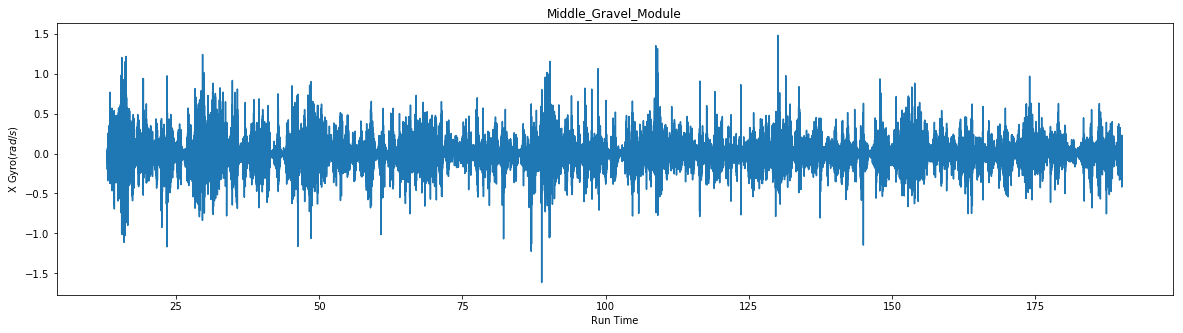

In [144]:
# Test plot - Data range is cutoff!
plot_one('Middle_Gravel_Module', 'X Gyro', 'Run Time')

In [10]:
#Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(label, 'Z Gyro', 'Run Time', save_fig=True)

In [11]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel(dirn)
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

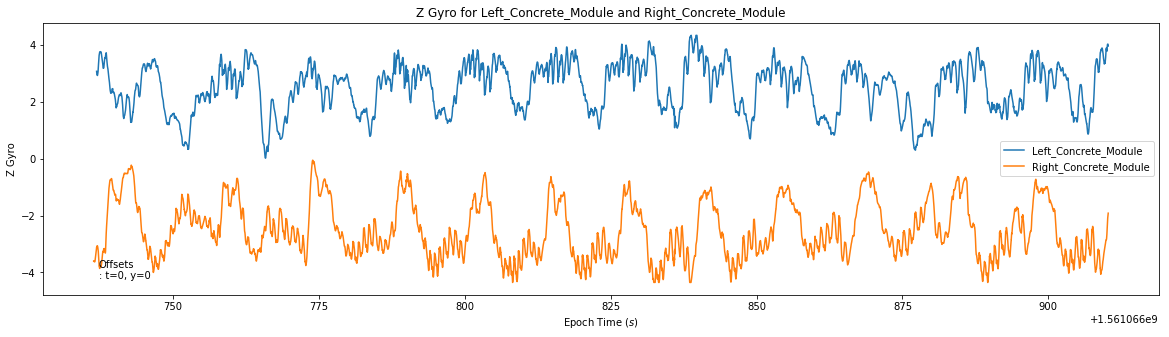

In [12]:
# Compare Z Z Gyro data for each wheel in the same dataset
dataset_compare(raw_datasets, 'Left_Concrete_Module',
                raw_datasets, 'Right_Concrete_Module', 
                dirn='Z Gyro')

In [13]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis)
        axes[i].set_ylabel(y_axis)
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

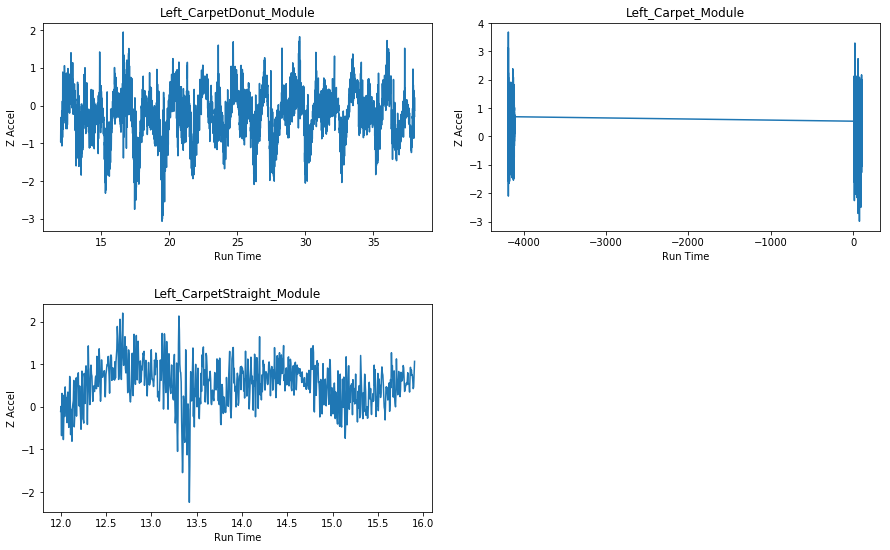

In [138]:
# Plot Z Accel of some datasets
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Left' in label and 'Carpet' in label}
plot_all(np_to_pd(datasets_to_plot), x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [190]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.as_matrix()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [191]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [146]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [142]:
# Run to convert back to Pandas
raw_datasets = np_to_pd(raw_datasets)

In [19]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 96
Shape of first dataset: (1496, 8)


Structure of data:

`Terrain Dataset Dictionary -> NP Array with Row = Datapoint, Col = Direction | Time`

## Part 2 - Filtering

In [20]:
'''Get frequencies for given label'''
def get_frequencies(label):
    # Sampling frequency varies for different devices (old datasets only)
    if ('Frame' in label):
        f_samp = 100 # Sampling frequency
        f_low = 20 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    else:
        f_samp = 200 # Sampling frequency
        f_low = 40 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
        
    return f_samp, f_low, f_high

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

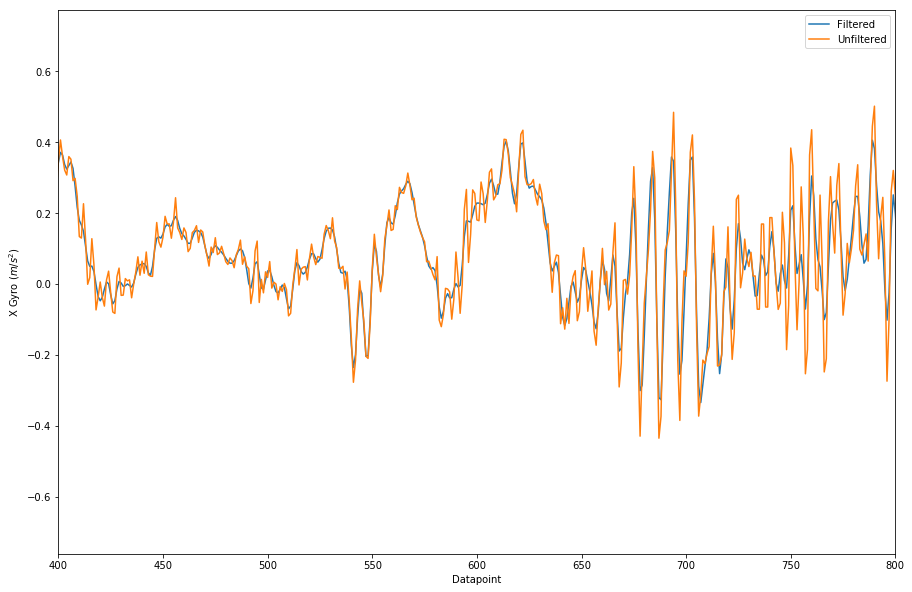

In [150]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(datasets[dataset_labels[0]][:, 3], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 3], label='Unfiltered')
plt.xlim(400, 800)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Gyro ($m/s^2$)')
plt.show()

In [22]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 96
Shape of first filtered dataset: (1496, 8)


In [23]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-10.212599,10.539363,-1.476459,-0.062371,-0.092068,4.34627,12.000000,1.561068e+09
1,-7.403647,8.995480,-0.079900,-0.125435,-0.121115,4.34627,12.004864,1.561068e+09
2,-5.980811,8.346094,0.698915,-0.154378,-0.129631,4.34627,12.009984,1.561068e+09
3,-6.117356,8.792052,0.810322,-0.137398,-0.120211,4.34627,12.014848,1.561068e+09
4,-6.823964,9.787851,0.638745,-0.093449,-0.110824,4.34627,12.019968,1.561068e+09


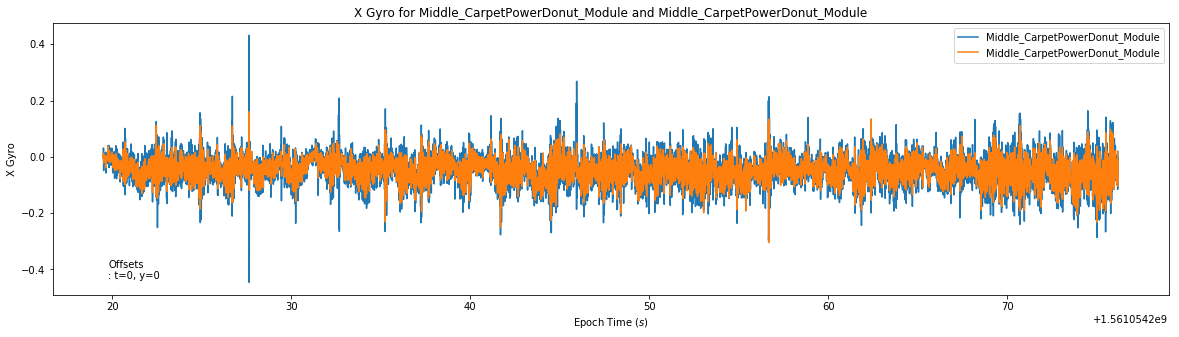

In [151]:
# Compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[1], 
                np_to_pd(datasets), dataset_labels[1], 'X Gyro')

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. 

Plot classification accuracy and time vs window size and find an optimal size

### Part (b) - Creating Time Windowed Data

In [25]:
# TODO: Create an array of different window sizes, taking out the desired array so don't have to rename things

WINDOW_SIZE = 200 # Divide by F_SAMP to get window size in seconds
datasets_windowed = {}

#raw_datasets = {label: dataset for label, dataset in raw_datasets.items() if 'Middle' in label}
# Trim excess datapoints, then split into windows
for label, dataset in raw_datasets.items():   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

Middle_SidewalkPowerDonut_Module
Right_AsphaltStraight_Module
Left_LinoleumStraight_Module
Left_GravelDonut_Module
Left_Concrete_Module
Middle_GrassStraight_Module
Right_GrassDonut_Module
Middle_LinoleumDonut_Module
Right_AsphaltDonut_Module
Middle_Sidewalk_Module
Middle_SidewalkStraight_Module
Left_GravelStraight_Module
Middle_GravelPower_Module
Right_AsphaltStraight2_Module
Middle_ConcretePower_Module
Middle_CarpetDonut_Module
Right_SidewalkDonut_Module
Middle_AsphaltPower_Module
Middle_GrassPowerStraight_Module
Middle_Asphalt_Module
Middle_AsphaltPowerStraight2_Module
Right_ConcreteDonut_Module
Middle_LinoleumStraight_Module
Middle_CarpetStraight_Module
Middle_GrassPower_Module
Right_Asphalt_Module
Middle_SidewalkPower_Module
Middle_AsphaltStraight2_Module
Middle_AsphaltPowerStraight_Module
Middle_AsphaltPowerDonut_Module
Middle_SidewalkDonut_Module
Left_SidewalkStraight2_Module
Middle_GrassPowerStraight2_Module
Right_Gravel_Module
Left_Linoleum_Module
Left_ConcreteStraight2_Module


In [26]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 96
Num of windows in first dataset: 7
Shape of individual window: (200, 8)


Structure of windowed data:

`Terrain Dataset Dictionary -> Window List -> NP Array with Row = Datapoint, Col = Direction | Time`

In [27]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
195,-0.950484,12.510709,-0.296278,0.048626,-0.291364,4.34627,12.974848,1.561068e+09
196,0.174774,11.978008,2.425888,0.103754,-0.288434,4.34627,12.979968,1.561068e+09
197,1.566981,13.318740,3.172867,0.063407,-0.311071,4.34627,12.984832,1.561068e+09
198,1.256937,13.081718,-0.347752,-0.068686,-0.346358,4.34627,12.989952,1.561068e+09
199,2.325931,9.762208,-0.048482,-0.056569,-0.270058,4.34627,12.995072,1.561068e+09


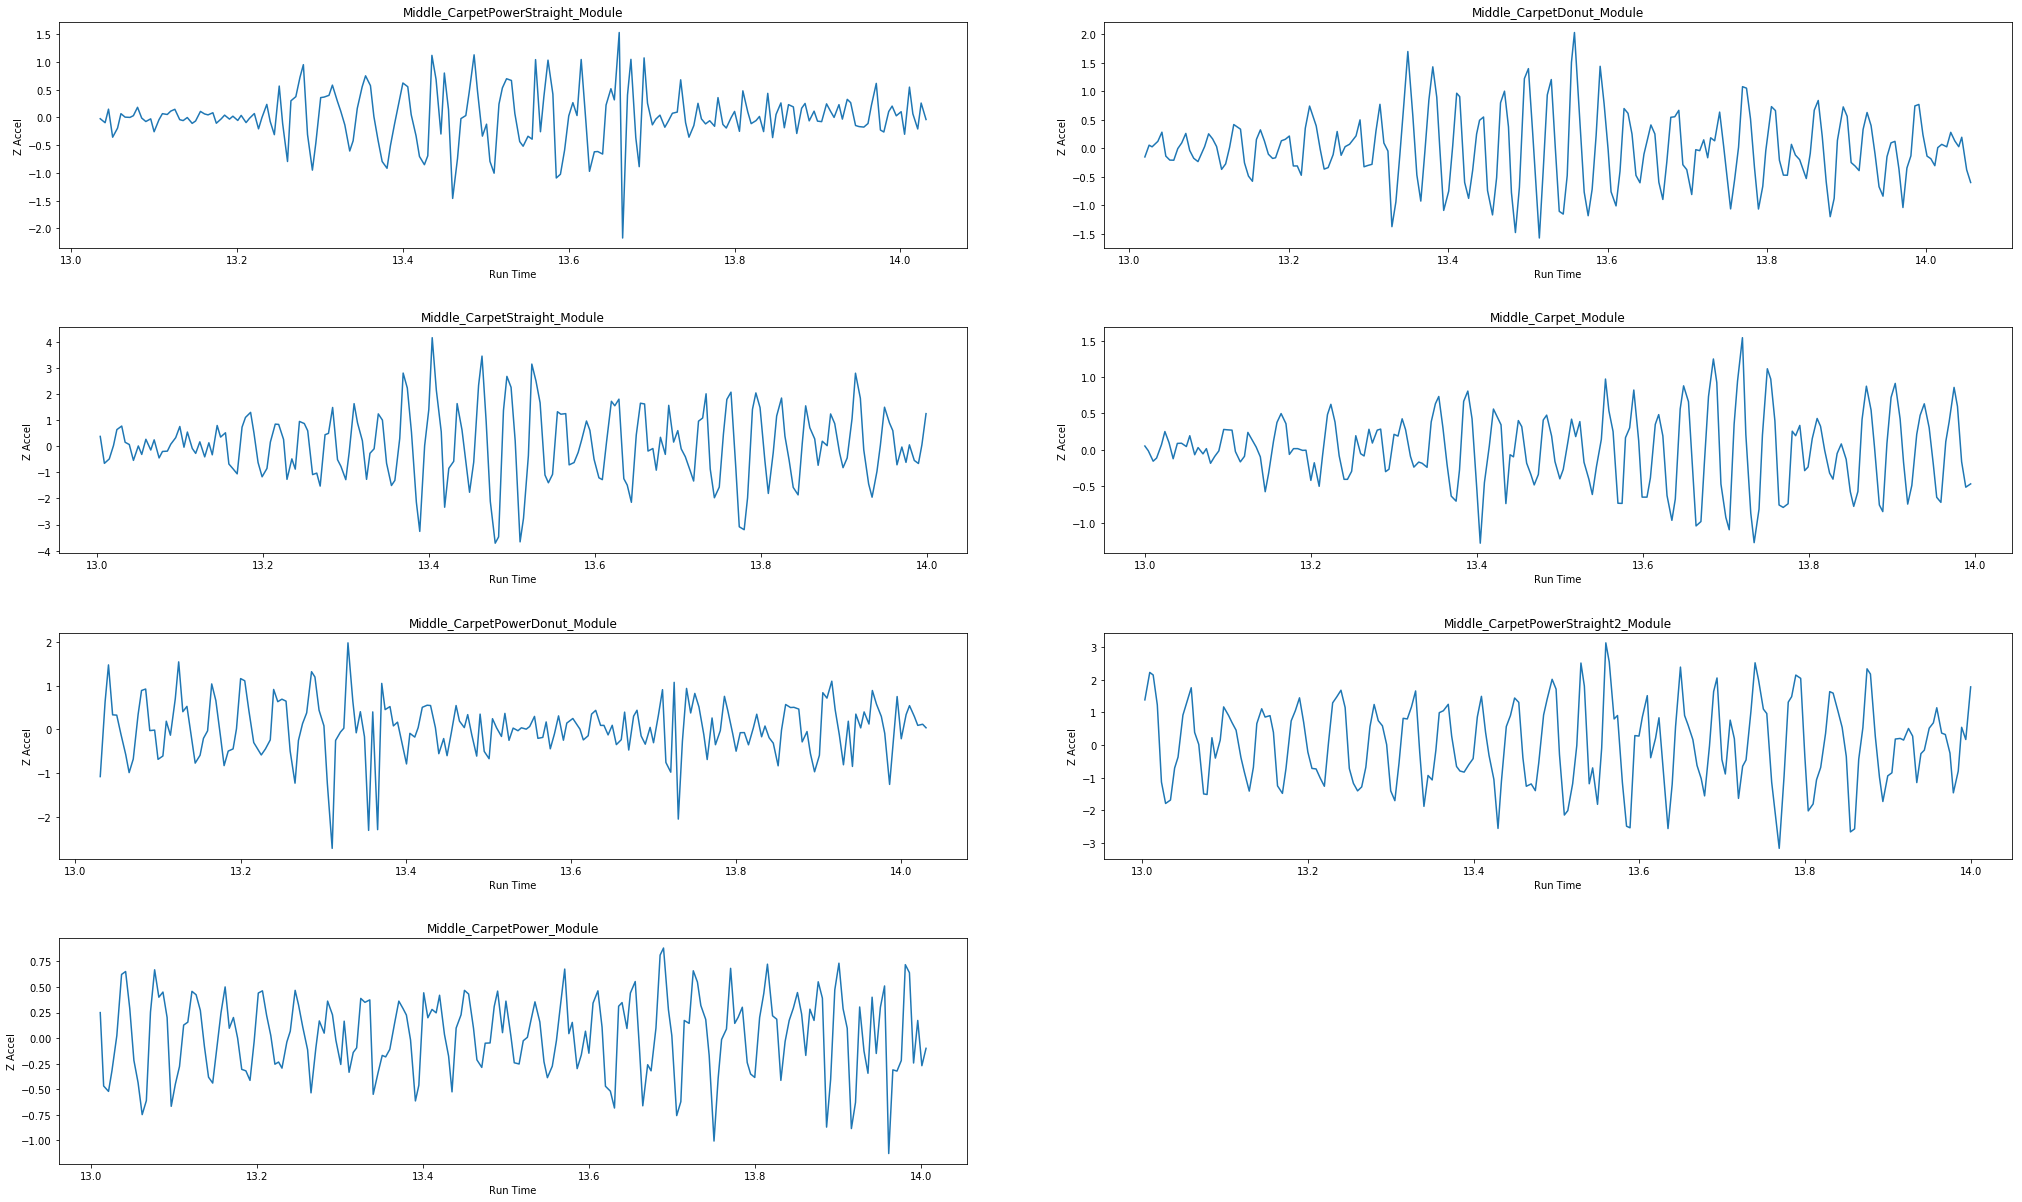

In [28]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Middle' in label and 'Carpet' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Z Accel', windowed=True, win_num=0)

## Part 4 - Transforms

In [29]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + data_columns[dirn] + 
              ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    plt.show()

### Part (a) - FFT

In [30]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), WINDOW_SIZE)), n_bins)
            
        freq_col = np.transpose([np.linspace(0.0, f_samp / 2, n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [31]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 96
Num of FFT'd windows in first dataset: 27
Shape of FFT'd individual window: (100, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,1.490356,4.037155,0.367026,0.030731,0.169896,4.34627,0.000000
1,4.177838,4.729069,0.243240,0.027139,0.006683,0.00000,1.010101
2,1.768275,1.093570,0.123908,0.025268,0.015208,0.00000,2.020202
3,0.629544,0.201590,0.077053,0.023679,0.017575,0.00000,3.030303
4,0.381022,0.204997,0.069677,0.002362,0.024744,0.00000,4.040404


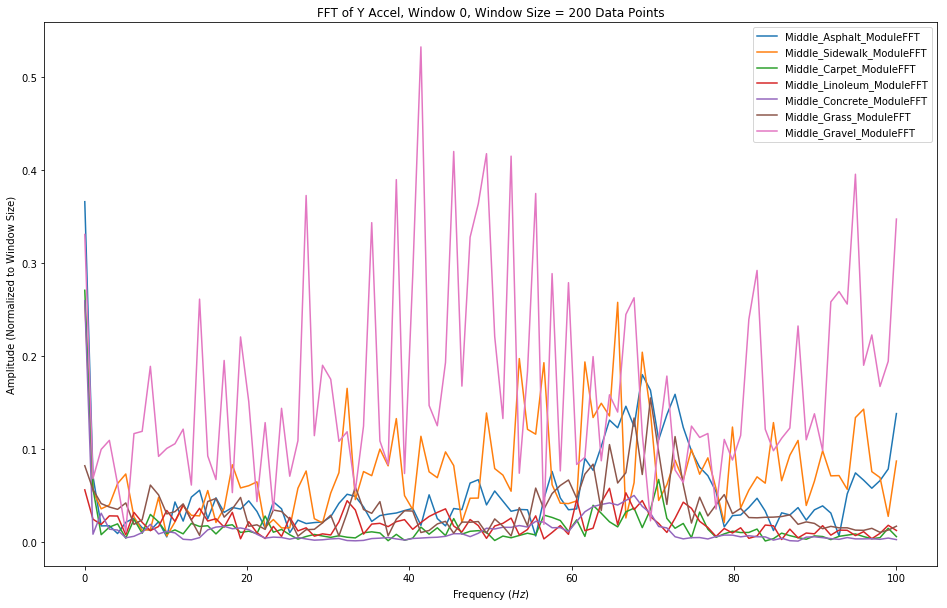

In [166]:
# Plot Z Accel of 0th window, Frame only
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), win_num=0, dirn=1, transform_name='FFT')

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

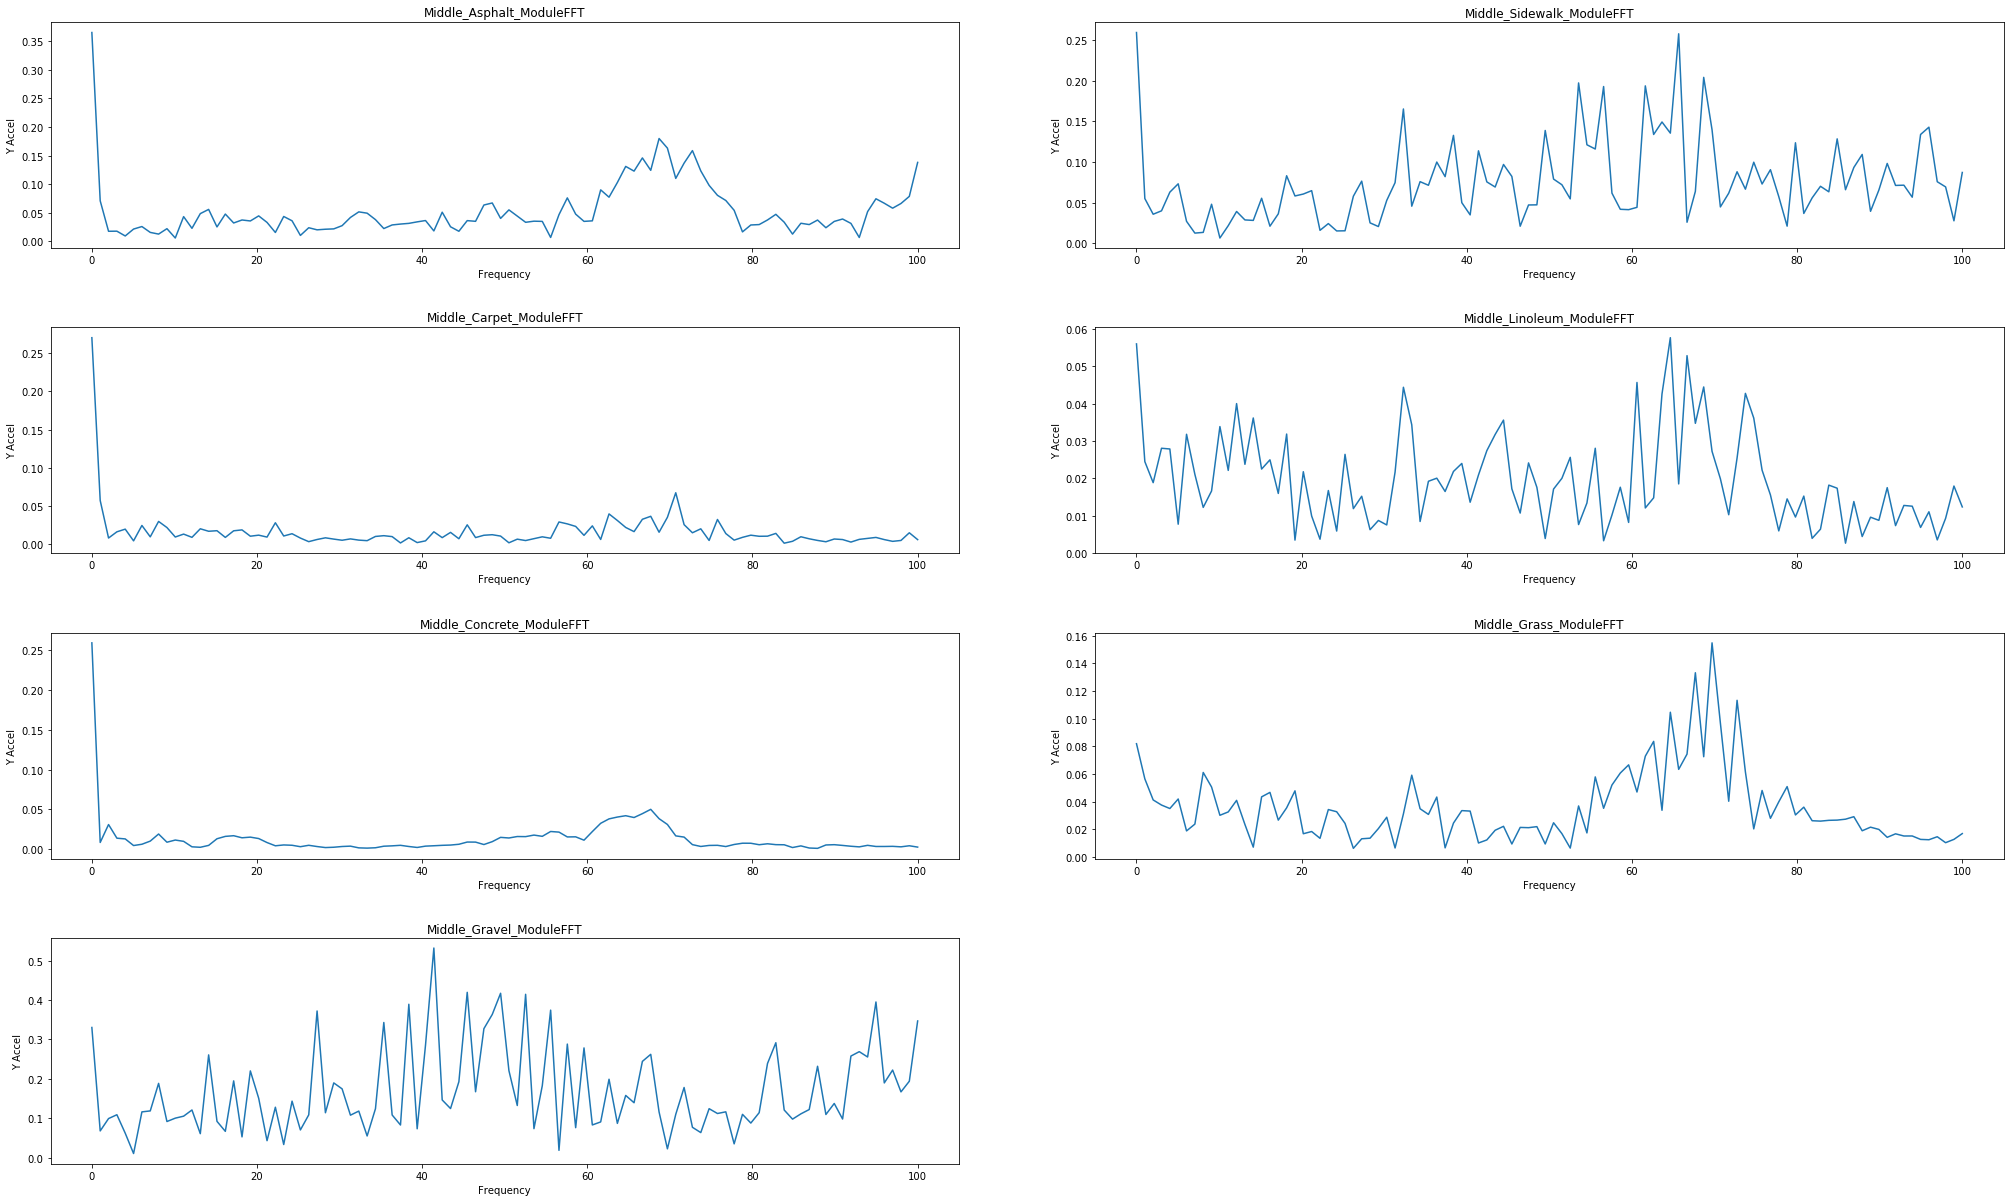

In [167]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Y Accel', windowed=True)

### Part (b) - PSD

In [34]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            window_psd_log[:, i] = np.log10(window_psd[:, i])
            
        # Append freq column
        freq_col = np.transpose([freq[:-1]])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


In [35]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 96
Num of PSD'd windows in first dataset: 7
Shape of PSD'd individual window: (100, 7)


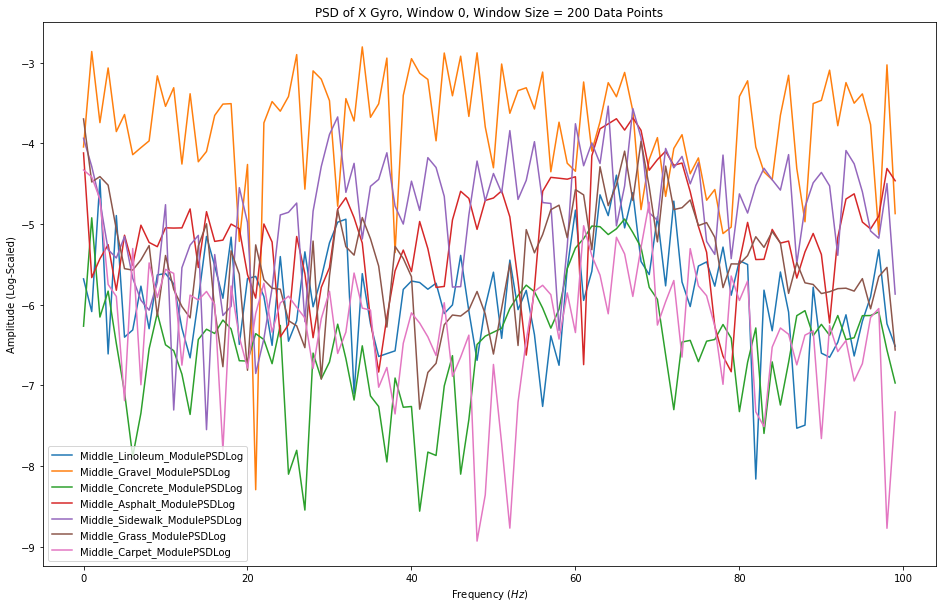

In [160]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(psds_to_plot, windowed=True), win_num=0, dirn=3, transform_name='PSD')

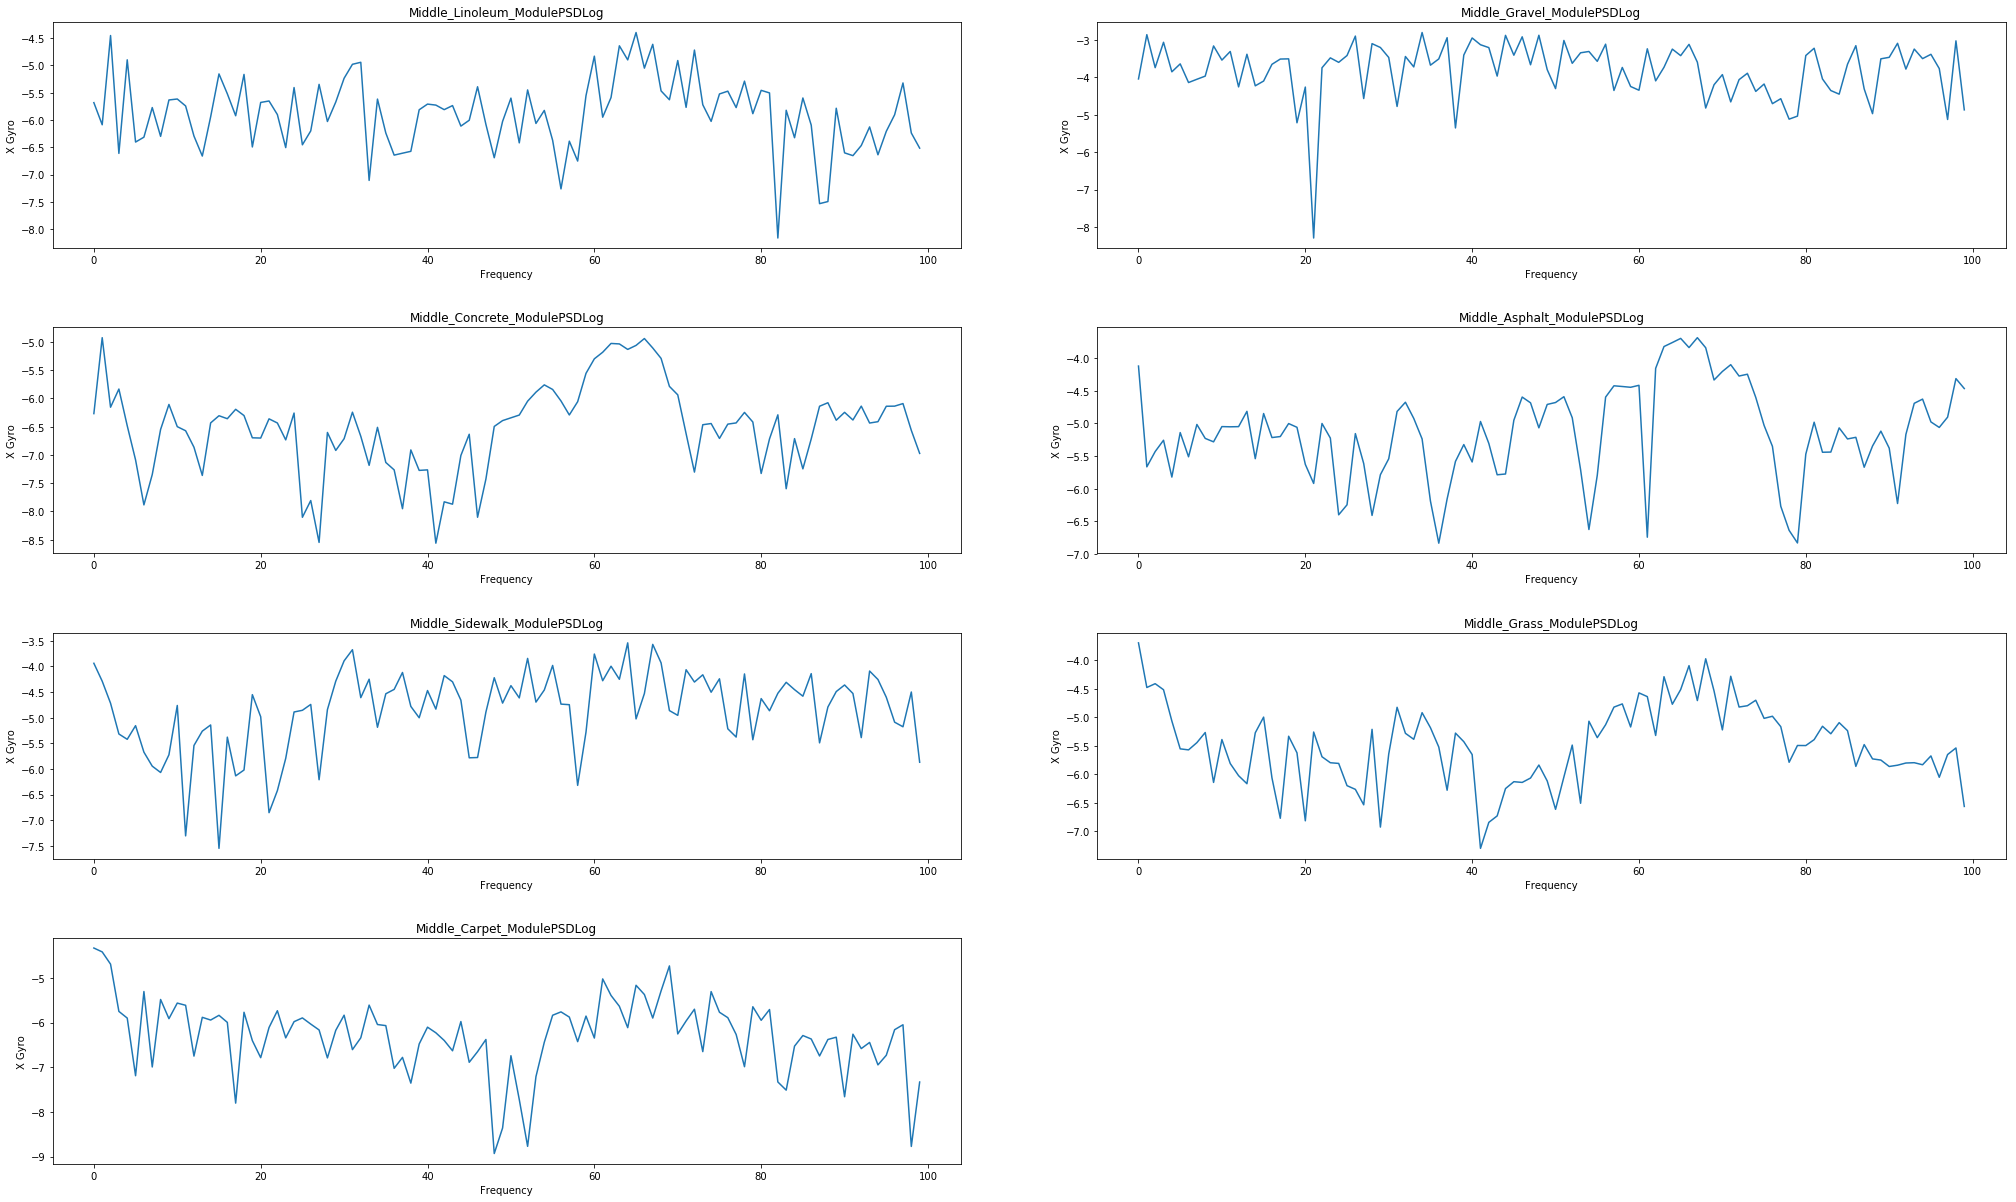

In [161]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array Col = Dirn | Frequency)`

### Part (c) - 3D Visualization

In [38]:
'''Plot the set transforms in 3d'''
# TODO: Convert to bar graphs for better representation
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if (transform_name == 'FFT'):
        ax.set_zlim(0, 0.8)
        ax.set_zlabel('Amplitude (Normalized)')
    elif (transform_name == 'PSD'):
        ax.set_zlim(-20, 10)
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    # Change y axis to correspond with whats being plotted
    n_datasets = len(datasets_transformed)
    ax.set_ylim(0, n_datasets)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1))
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + 
                 ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
        
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        ax.plot(xs=dataset[win_num][:, -1], ys=dataset[win_num][:, dirn],
                zs=i+1, zdir='y', label=label)
    
    ax.legend()
    plt.show()

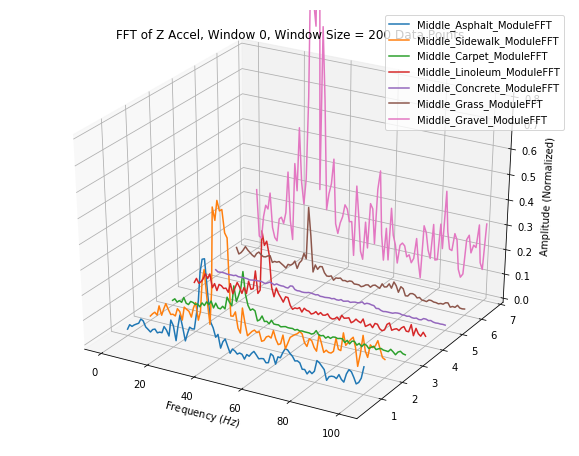

In [164]:
# Plot 3d Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(pd_to_np(ffts_to_plot, windowed=True), win_num=0, dirn=1, transform_name='FFT')

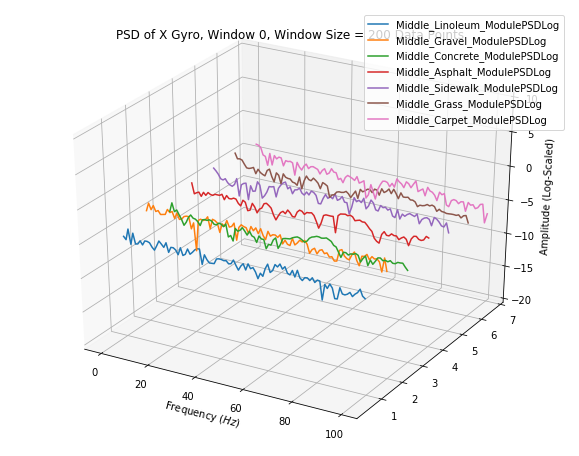

In [168]:
# Plot 3d Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(pd_to_np(psds_to_plot, windowed=True), win_num=0, dirn=3, transform_name='PSD')

### Part (d) - Spectograms

In [41]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size=WINDOW_SIZE):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 9))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

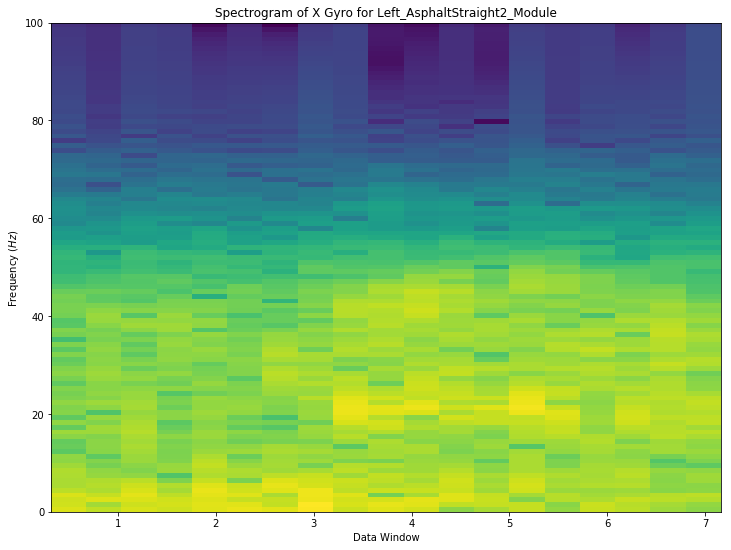

In [170]:
# X Accel
plot_spectogram(dataset_labels[0], dirn=3, size=200)

## Part 5 - Feature Extraction

Structure of feature data:

`Terrain Dataset Dictionary -> Direction Dictionary -> Pandas Array with Row = Window #, Col = Feature`

In [43]:
# Feature extraction functions

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [44]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [45]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(dirn + ', Window Size = {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [46]:
# Time domain feature function names and actual names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [47]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 96
Num directions: 6
Shape of first dataset first direction: (7, 10)


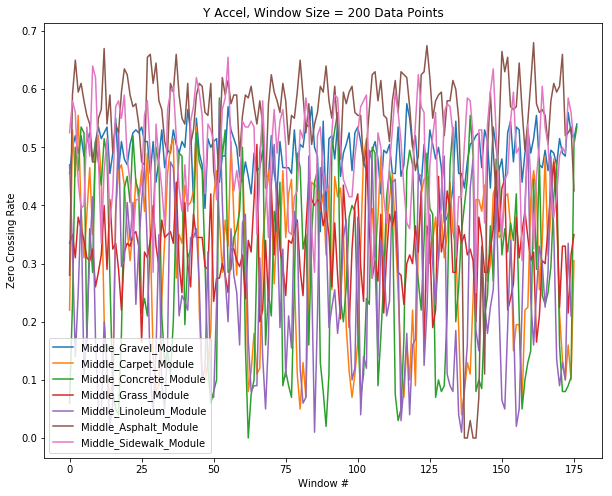

In [66]:
# Plot Max of Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Zero Crossing Rate')

### Part (b) - Frequency Domain Features

In [49]:
# Time domain feature function names and actual names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Calculate features for each window of each column of each dataset
# Create array of features of each window for each dataset and direction
# TODO: Check if psd is correct
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide


In [50]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 96
Num directions: 6
Shape of one direction: (7, 5)


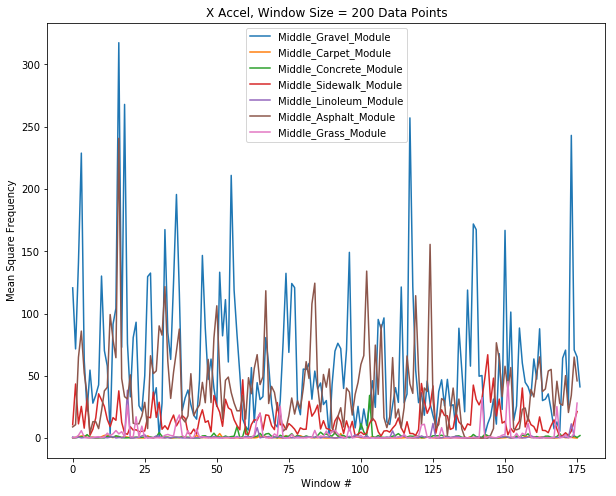

In [68]:
# Plot RVF of Z Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label }
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Mean Square Frequency')

Lots of very similar shapes i.e. highly correlated variables in both time and frequency. Need to implement feature selection.

**Ideally we can implement feature selection over all directions, with FFT + PSD + Time Features + Freq Features**

## Part 6 - Standardization and Dataset Combining

In [52]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [53]:
# Confirm formatting
datasets_fft[dataset_labels[0]+'FFT'][0].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,1.490356,4.037155,0.367026,0.030731,0.169896,4.34627,0.000000
1,4.177838,4.729069,0.243240,0.027139,0.006683,0.00000,1.010101
2,1.768275,1.093570,0.123908,0.025268,0.015208,0.00000,2.020202
3,0.629544,0.201590,0.077053,0.023679,0.017575,0.00000,3.030303
4,0.381022,0.204997,0.069677,0.002362,0.024744,0.00000,4.040404


In [54]:
# Add time and freq features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [77]:
# Confirm formatting
datasets_feat['Middle_Carpet_Module']['Y Accel'].head()

,Autocorrelation,Excess Kurtosis,L2 Norm,Max,Mean,Min,Root Mean Squared,Skew,Std Dev,Zero Crossing Rate,Frequency Center,Mean Square Frequency,Root Mean Square Frequency,Root Variance Frequency,Variance Frequency
0,26.781516,0.424723,5.175086,0.808894,0.270446,-0.498640,0.365934,-0.475714,0.246508,0.220,46.374792,0.146315,0.382511,0.382511,-2150.474991
1,149.052247,21.231529,12.208696,3.989121,0.048609,-5.688062,0.863285,-2.623446,0.861916,0.530,61.712283,1.866859,1.366330,1.366330,-3806.538960
2,34.003524,0.142940,5.831254,0.938210,-0.032585,-1.327223,0.412332,-0.231445,0.411042,0.450,48.015139,0.273763,0.523224,0.523224,-2305.179850
3,75.033963,0.253753,8.662215,1.345318,-0.101650,-1.928305,0.612511,-0.320269,0.604017,0.555,46.391887,0.432593,0.657718,0.657718,-2151.774569
4,86.120716,-0.477454,9.280125,1.132185,-0.321644,-1.707988,0.656204,-0.079272,0.571969,0.390,47.952160,0.354197,0.595145,0.595145,-2299.055498


### Part (a) - Standardization

Standardize each feature to mean 0 and standard deviation 1. This will make PCA and classification easier.

In [227]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(pre.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [57]:
# So we can remove infinites
pd.set_option('use_inf_as_null', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

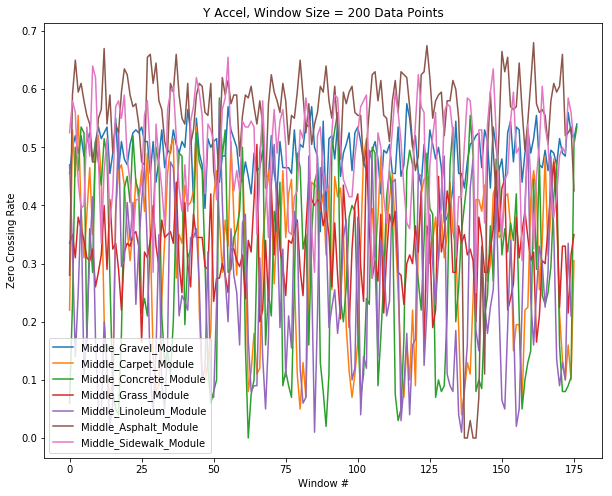

In [79]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Zero Crossing Rate')

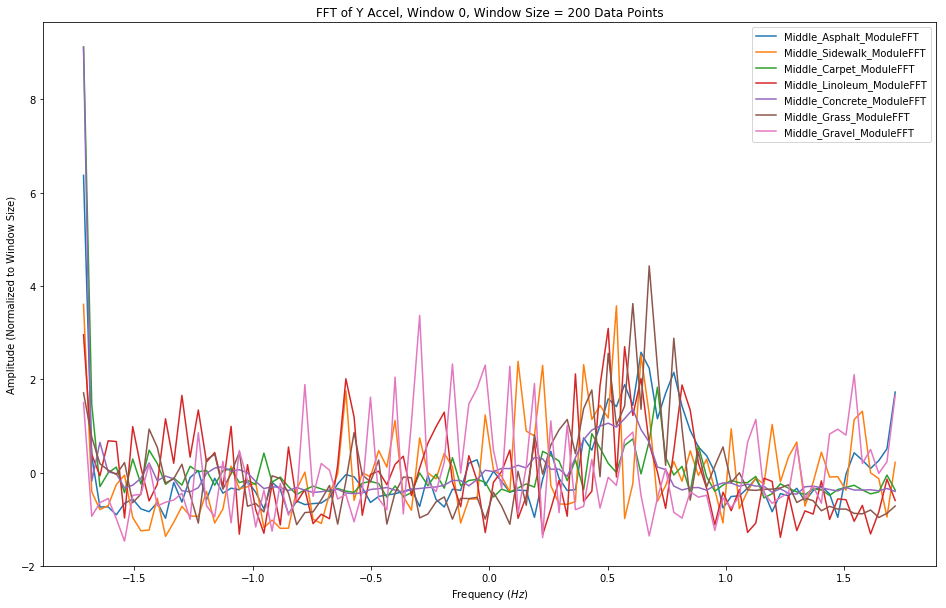

In [81]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label and 'Power' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [60]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [61]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [63]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Check dataset
datasets_feat_columned[dataset_labels[3]].head()

,Autocorrelation Z Accel Left,Excess Kurtosis Z Accel Left,L2 Norm Z Accel Left,Max Z Accel Left,Mean Z Accel Left,Min Z Accel Left,Root Mean Squared Z Accel Left,Skew Z Accel Left,Std Dev Z Accel Left,Zero Crossing Rate Z Accel Left,...,Min Y Accel Left,Root Mean Squared Y Accel Left,Skew Y Accel Left,Std Dev Y Accel Left,Zero Crossing Rate Y Accel Left,Frequency Center Y Accel Left,Mean Square Frequency Y Accel Left,Root Mean Square Frequency Y Accel Left,Root Variance Frequency Y Accel Left,Variance Frequency Y Accel Left
0,-0.389482,-0.021449,-0.330594,0.379621,-0.282680,-0.395885,-0.330594,-0.922274,0.651146,0.180256,...,-0.249377,0.412734,-1.160049,1.076117,0.046545,-0.398666,0.481229,0.669948,0.669948,0.287439
1,-0.206964,-0.840527,-0.097174,-0.623705,-1.424787,-0.472281,-0.097174,0.577955,0.411740,0.637167,...,-0.746954,0.010885,1.035144,1.128830,-0.711470,-0.393080,0.577255,0.745934,0.745934,0.286909
2,-0.095557,-0.583942,0.037277,0.136147,-0.524887,-0.421657,0.037277,-0.012486,1.205121,0.883195,...,-0.316673,0.355228,-1.245890,0.938542,1.562575,-0.347652,0.767374,0.890249,0.890249,0.280748
3,1.842560,2.108436,1.840911,1.595652,-1.758451,-3.209658,1.840911,-0.950434,2.781915,0.285697,...,-0.962941,0.034474,1.008913,1.509996,0.804560,-0.353496,1.553747,1.420919,1.420919,0.283498
4,-0.306567,-0.194424,-0.222356,-1.103964,-1.292471,-0.865307,-0.222356,-1.332986,0.423879,0.812901,...,-0.881923,-0.236314,-0.093436,1.507310,0.046545,-0.334995,2.754753,2.097196,2.097196,0.283442


#### Part (ii) - Transformed Data

In [88]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in data_columns:
                    combined_column_name = data_column + ' {} Hz'.format(round(row[1]['Frequency'], 0))
                    combined_column_name.append(' ' + get_transform(label) + get_placement(label))
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [89]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [90]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [91]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,Z Gyro 100.0 Hz,Y Gyro 100.0 Hz,X Gyro 100.0 Hz,Z Accel 100.0 Hz,Y Accel 100.0 Hz,X Accel 100.0 Hz,Z Gyro 99.0 Hz,Y Gyro 99.0 Hz,X Gyro 99.0 Hz,Z Accel 99.0 Hz,...,X Gyro 1.0 Hz,Z Accel 1.0 Hz,Y Accel 1.0 Hz,X Accel 1.0 Hz,Z Gyro 0.0 Hz,Y Gyro 0.0 Hz,X Gyro 0.0 Hz,Z Accel 0.0 Hz,Y Accel 0.0 Hz,X Accel 0.0 Hz
0,0.0,0.000534,0.001650,0.078114,0.037937,0.043630,0.0,0.000510,0.000950,0.025397,...,0.027139,0.243240,4.729069,4.177838,4.34627,0.169896,0.030731,0.367026,4.037155,1.490356
1,0.0,0.001480,0.003317,0.047026,0.063562,0.100199,0.0,0.002414,0.001127,0.039407,...,0.011689,0.159435,3.785102,4.674479,4.34627,0.193491,0.042102,0.276951,3.129024,0.830231
2,0.0,0.001051,0.000971,0.096783,0.062774,0.030907,0.0,0.003184,0.003610,0.084023,...,0.019195,0.187578,4.663292,3.977974,4.34627,0.163589,0.076432,0.292717,0.653643,0.057837
3,0.0,0.005351,0.003315,0.151929,0.048318,0.164058,0.0,0.001359,0.001492,0.187178,...,0.062291,0.325130,4.069982,4.930211,4.34627,0.193614,0.080059,0.096132,1.881508,2.671703
4,0.0,0.002577,0.002718,0.091473,0.047254,0.134066,0.0,0.000942,0.001532,0.047887,...,0.003430,0.039733,5.066801,4.133540,4.34627,0.238960,0.009253,0.422977,3.308320,1.093313
5,0.0,0.001073,0.003471,0.076607,0.137468,0.103861,0.0,0.001079,0.001325,0.063853,...,0.013143,0.109450,4.229305,4.782022,4.34627,0.207392,0.020142,0.473105,2.663574,0.617198
6,0.0,0.002007,0.001192,0.058192,0.009096,0.032111,0.0,0.002039,0.001098,0.015166,...,0.007346,0.025564,4.566620,4.253802,4.34627,0.221293,0.016855,0.388064,0.505929,0.083652


In [94]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,Z Gyro 99.0 Hz,Y Gyro 99.0 Hz,X Gyro 99.0 Hz,Z Accel 99.0 Hz,Y Accel 99.0 Hz,X Accel 99.0 Hz,Z Gyro 98.0 Hz,Y Gyro 98.0 Hz,X Gyro 98.0 Hz,Z Accel 98.0 Hz,...,X Gyro 1.0 Hz,Z Accel 1.0 Hz,Y Accel 1.0 Hz,X Accel 1.0 Hz,Z Gyro 0.0 Hz,Y Gyro 0.0 Hz,X Gyro 0.0 Hz,Z Accel 0.0 Hz,Y Accel 0.0 Hz,X Accel 0.0 Hz
0,NaN,-7.995371,-5.574638,-2.179629,-3.668544,-3.198900,NaN,-6.244075,-5.264153,-1.913507,...,-2.893839,-1.512774,0.378723,0.796130,NaN,-4.049049,-2.831790,-0.926902,1.650581,1.542933
1,NaN,-5.626853,-6.587139,-1.798689,-2.474510,-1.580226,NaN,-5.358457,-4.657414,-2.354286,...,-2.753401,-1.336584,0.949292,0.671338,NaN,-3.869323,-3.563430,-1.293801,1.457185,1.640496
2,NaN,-6.933090,-6.055503,-3.482067,-1.895281,-2.844240,NaN,-5.656071,-5.724702,-1.727370,...,-3.103935,-1.516770,0.584439,0.877014,NaN,-2.621998,-3.132595,-1.152606,1.638415,1.500354
3,NaN,-6.381576,-5.159471,-2.061402,-2.366746,-1.518593,NaN,-4.242130,-4.658001,-1.335690,...,-2.818808,-0.934135,0.678904,0.282916,NaN,-2.697550,-2.110116,-0.674856,1.520215,1.686761
4,NaN,-5.907372,-5.403436,-2.293842,-2.332193,-2.458322,NaN,-4.876579,-4.830559,-1.776382,...,-2.667974,-2.573430,-0.023325,0.617053,NaN,-3.226086,-4.628486,-2.500675,1.710498,1.533674
5,NaN,-6.208826,-5.734491,-1.642494,-3.883290,-3.008975,NaN,-5.637652,-4.618132,-1.930429,...,-4.862574,-1.911880,0.732841,0.447034,NaN,-3.190180,-3.461551,-1.620535,1.553568,1.660253
6,NaN,-5.956011,-4.935804,-1.730590,-1.922477,-3.468147,NaN,-5.093818,-5.546760,-2.169248,...,-3.268823,-1.708246,0.697084,0.741165,NaN,-4.051261,-3.966926,-2.883710,1.620220,1.558585


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [84]:
'Add labels to a dataset'
# TODO: Make this return a new dataframe
def insert_labels(datasets):
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        dataset.insert(0, 'Label', labels)

In [95]:
# Add labels
insert_labels(datasets_feat_columned)
insert_labels(datasets_fft_columned)
insert_labels(datasets_psd_log_columned)

In [96]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]]

,Label,Autocorrelation Z Accel Left,Excess Kurtosis Z Accel Left,L2 Norm Z Accel Left,Max Z Accel Left,Mean Z Accel Left,Min Z Accel Left,Root Mean Squared Z Accel Left,Skew Z Accel Left,Std Dev Z Accel Left,...,Min Y Accel Left,Root Mean Squared Y Accel Left,Skew Y Accel Left,Std Dev Y Accel Left,Zero Crossing Rate Y Accel Left,Frequency Center Y Accel Left,Mean Square Frequency Y Accel Left,Root Mean Square Frequency Y Accel Left,Root Variance Frequency Y Accel Left,Variance Frequency Y Accel Left
0,3,-1.067295,-0.868644,-1.128186,-1.086935,0.312992,1.209218,-1.128186,0.080711,-1.141184,...,1.420544,0.981104,-1.412809,-0.497732,-1.238852,-1.196273,-1.508189,-1.719006,-1.719006,0.971244
1,3,-1.066141,0.461333,-1.126098,-1.330246,-0.469492,0.729613,-1.126098,-0.724491,-1.115756,...,0.535620,-0.764217,-0.778506,-1.666799,-1.004474,-0.671005,0.787452,0.784847,0.784847,0.784131
2,3,-1.003130,2.016044,-1.016462,-0.781782,-0.332535,1.118655,-1.016462,1.944794,-1.008207,...,0.547714,-1.103095,1.270778,-0.191952,-0.770097,-1.091299,-1.227102,-1.191346,-1.191346,0.936049
3,3,1.560288,0.235145,1.388418,1.557047,-2.040284,-1.780664,1.388418,0.830319,1.404988,...,-2.013325,-0.257276,0.182277,0.298013,1.808054,1.713168,1.544234,1.288857,1.288857,-1.969821
4,3,0.718388,-0.926223,0.795480,0.609654,0.799048,-0.475779,0.795480,-0.877579,0.789002,...,-0.579103,1.937181,-0.187417,1.886536,0.167412,0.692469,0.281307,0.404159,0.404159,-0.527994
5,3,0.875815,-1.021840,0.914094,0.749558,1.234513,-0.266164,0.914094,-0.157382,0.900340,...,0.079047,-0.170184,-0.606328,-0.284566,0.636167,0.700981,0.314363,0.430380,0.430380,-0.537215
6,3,-0.017925,0.104185,0.172753,0.282705,0.495757,-0.534879,0.172753,-1.096373,0.170817,...,0.009503,-0.623512,1.532005,0.456500,0.401790,-0.148041,-0.192065,0.002110,0.002110,0.343605


In [97]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,Label,Z Gyro 100.0 Hz,Y Gyro 100.0 Hz,X Gyro 100.0 Hz,Z Accel 100.0 Hz,Y Accel 100.0 Hz,X Accel 100.0 Hz,Z Gyro 99.0 Hz,Y Gyro 99.0 Hz,X Gyro 99.0 Hz,...,X Gyro 1.0 Hz,Z Accel 1.0 Hz,Y Accel 1.0 Hz,X Accel 1.0 Hz,Z Gyro 0.0 Hz,Y Gyro 0.0 Hz,X Gyro 0.0 Hz,Z Accel 0.0 Hz,Y Accel 0.0 Hz,X Accel 0.0 Hz
0,3,0.0,0.000534,0.001650,0.078114,0.037937,0.043630,0.0,0.000510,0.000950,...,0.027139,0.243240,4.729069,4.177838,4.34627,0.169896,0.030731,0.367026,4.037155,1.490356
1,3,0.0,0.001480,0.003317,0.047026,0.063562,0.100199,0.0,0.002414,0.001127,...,0.011689,0.159435,3.785102,4.674479,4.34627,0.193491,0.042102,0.276951,3.129024,0.830231
2,3,0.0,0.001051,0.000971,0.096783,0.062774,0.030907,0.0,0.003184,0.003610,...,0.019195,0.187578,4.663292,3.977974,4.34627,0.163589,0.076432,0.292717,0.653643,0.057837
3,3,0.0,0.005351,0.003315,0.151929,0.048318,0.164058,0.0,0.001359,0.001492,...,0.062291,0.325130,4.069982,4.930211,4.34627,0.193614,0.080059,0.096132,1.881508,2.671703
4,3,0.0,0.002577,0.002718,0.091473,0.047254,0.134066,0.0,0.000942,0.001532,...,0.003430,0.039733,5.066801,4.133540,4.34627,0.238960,0.009253,0.422977,3.308320,1.093313
5,3,0.0,0.001073,0.003471,0.076607,0.137468,0.103861,0.0,0.001079,0.001325,...,0.013143,0.109450,4.229305,4.782022,4.34627,0.207392,0.020142,0.473105,2.663574,0.617198
6,3,0.0,0.002007,0.001192,0.058192,0.009096,0.032111,0.0,0.002039,0.001098,...,0.007346,0.025564,4.566620,4.253802,4.34627,0.221293,0.016855,0.388064,0.505929,0.083652


### Part (d) - Combining Datasets

In [98]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [176]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        datasets_separated.update({placement: combine_datasets(datasets).dropna()})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [111]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features')

feat_combined['Middle'].head()

,Label,Autocorrelation Z Accel Middle,Excess Kurtosis Z Accel Middle,L2 Norm Z Accel Middle,Max Z Accel Middle,Mean Z Accel Middle,Min Z Accel Middle,Root Mean Squared Z Accel Middle,Skew Z Accel Middle,Std Dev Z Accel Middle,...,Min Y Accel Middle,Root Mean Squared Y Accel Middle,Skew Y Accel Middle,Std Dev Y Accel Middle,Zero Crossing Rate Y Accel Middle,Frequency Center Y Accel Middle,Mean Square Frequency Y Accel Middle,Root Mean Square Frequency Y Accel Middle,Root Variance Frequency Y Accel Middle,Variance Frequency Y Accel Middle
0,5,1.987177,0.517264,1.719114,1.178683,0.379737,-0.889721,1.719114,1.307110,1.719708,...,-0.922057,1.346499,-1.537555,1.338937,0.607433,0.837182,0.693770,0.754741,0.754741,-0.819271
1,5,1.546260,-0.623702,1.418566,0.643944,1.194893,-0.889721,1.418566,0.307533,1.418739,...,-1.882015,1.190385,-1.050752,1.193679,-1.003101,-1.136114,0.254947,0.383714,0.383714,1.126085
2,5,0.493260,1.065960,0.604623,1.305700,-1.981912,-0.889721,0.604623,0.808728,0.599898,...,-0.198323,0.318771,0.106795,0.307922,-0.245202,0.535735,1.217186,1.156766,1.156766,-0.483529
3,5,-0.704835,-0.791881,-0.622665,-0.749744,0.459197,1.162367,-0.622665,-0.222771,-0.620613,...,0.776013,-0.811587,0.217277,-0.805256,0.796908,-0.034202,-0.863519,-0.802994,-0.802994,0.100437
4,5,-0.626878,-0.602790,-0.525276,-0.470445,-0.132892,0.539900,-0.525276,-0.310020,-0.523664,...,0.852016,-0.905200,0.266597,-0.901591,0.039009,-0.281667,-0.990264,-0.975952,-0.975952,0.343732


In [112]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs')

fft_combined['Left'].head()

,Label,Z Gyro 100.0 Hz,Y Gyro 100.0 Hz,X Gyro 100.0 Hz,Z Accel 100.0 Hz,Y Accel 100.0 Hz,X Accel 100.0 Hz,Z Gyro 99.0 Hz,Y Gyro 99.0 Hz,X Gyro 99.0 Hz,...,X Gyro 1.0 Hz,Z Accel 1.0 Hz,Y Accel 1.0 Hz,X Accel 1.0 Hz,Z Gyro 0.0 Hz,Y Gyro 0.0 Hz,X Gyro 0.0 Hz,Z Accel 0.0 Hz,Y Accel 0.0 Hz,X Accel 0.0 Hz
0,2,0.000311,0.001018,0.004009,0.004682,0.011317,0.039517,0.000132,0.000946,0.003693,...,0.262261,0.236656,1.694730,3.690388,2.718030,0.425859,0.087259,0.382205,6.419738,0.942164
1,2,0.000351,0.002695,0.003243,0.007903,0.033693,0.041981,0.000392,0.002649,0.003272,...,0.152064,0.172332,2.284169,2.568517,2.610675,0.440466,0.293082,0.152993,6.052862,6.574796
2,2,0.000332,0.004401,0.001964,0.004194,0.046947,0.022072,0.000429,0.004287,0.001879,...,0.231850,0.024540,3.453496,1.991717,2.784496,0.148904,0.482732,0.326043,3.591301,4.630860
3,2,0.000779,0.003714,0.001033,0.004589,0.048748,0.017093,0.000663,0.003720,0.001098,...,0.237393,0.407611,4.122818,2.332259,3.079954,0.164565,0.524680,0.226554,3.165104,6.970121
4,2,0.000761,0.002730,0.000818,0.000958,0.045380,0.015903,0.000656,0.002703,0.000705,...,0.292461,0.262754,4.371912,3.045577,3.242166,0.113933,0.480385,0.486758,2.033723,3.227388


In [113]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs')

psd_log_combined['Right'].head()

,Label,Z Gyro 99.0 Hz,Y Gyro 99.0 Hz,X Gyro 99.0 Hz,Z Accel 99.0 Hz,Y Accel 99.0 Hz,X Accel 99.0 Hz,Z Gyro 98.0 Hz,Y Gyro 98.0 Hz,X Gyro 98.0 Hz,...,X Gyro 1.0 Hz,Z Accel 1.0 Hz,Y Accel 1.0 Hz,X Accel 1.0 Hz,Z Gyro 0.0 Hz,Y Gyro 0.0 Hz,X Gyro 0.0 Hz,Z Accel 0.0 Hz,Y Accel 0.0 Hz,X Accel 0.0 Hz
0,5,-5.619732,-6.176344,-6.348129,-3.662178,-2.886042,-2.960519,-5.380472,-5.709213,-5.725893,...,-3.352554,-1.387428,0.548173,0.363612,-1.072048,-2.326828,-2.486363,-1.524037,1.095377,0.942002
1,5,-5.231600,-5.626477,-5.908933,-3.987472,-3.348296,-3.282140,-4.946844,-5.332043,-5.689579,...,-2.232228,-1.487010,-0.332259,0.234570,-1.456843,-1.208406,-1.959108,-2.000959,0.122177,0.663259
2,5,-6.480298,-6.292125,-5.981108,-4.249217,-3.790685,-3.657259,-6.087359,-6.098519,-5.694743,...,-2.566643,-2.326567,-0.848481,-0.334377,-1.162849,-1.558772,-1.575798,-2.151471,-0.801693,-0.280724
3,5,-5.003787,-5.652441,-5.826053,-4.474061,-2.608808,-4.739633,-4.676055,-5.188271,-5.771126,...,-3.545569,-1.109719,0.329407,-0.751605,-0.320955,-1.525447,-2.423431,-0.981642,1.250724,-0.113727
4,5,-4.914331,-5.449752,-5.824162,-3.751542,-5.211811,-3.254599,-4.588998,-5.285747,-5.520255,...,-2.374312,-2.052758,-2.184065,-0.054954,-1.219580,-0.813488,-1.473314,-1.608810,-1.054149,0.722468


## Part 7 - Feature Selection mRMR (minimum Redunancy Maximum Relevance)

Try to find which features are most relevant, from all directions.

Features can be transforms or extracted features.

mRMR tries to find which features have the highest correlation to classified state and lowest correlation with other variables.

### Part (a) - Select Extracted Features

In [116]:
pymrmr.mRMR(data=feat_combined['Middle'], method='MID', nfeats=10)

['Min Z Accel Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Mean Square Frequency Y Accel Middle',
 'Mean Z Accel Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Variance Frequency X Accel Middle',
 'Skew Y Gyro Middle',
 'Variance Frequency Z Gyro Middle',
 'Excess Kurtosis Y Accel Middle']

In [118]:
pymrmr.mRMR(data=feat_combined['Left'], method='MID', nfeats=10)

['Zero Crossing Rate X Accel Left',
 'Zero Crossing Rate Y Accel Left',
 'Zero Crossing Rate X Gyro Left',
 'Excess Kurtosis Y Accel Left',
 'Frequency Center Z Gyro Left',
 'Frequency Center Y Accel Left',
 'Mean Square Frequency Z Accel Left',
 'Zero Crossing Rate Y Gyro Left',
 'Mean Square Frequency X Accel Left',
 'Excess Kurtosis Y Gyro Left']

In [117]:
pymrmr.mRMR(data=feat_combined['Right'], method='MID', nfeats=10)

['Zero Crossing Rate X Accel Right',
 'Zero Crossing Rate Z Accel Right',
 'Zero Crossing Rate Y Accel Right',
 'Zero Crossing Rate Z Gyro Right',
 'Frequency Center Y Gyro Right',
 'Frequency Center X Accel Right',
 'Max Y Accel Right',
 'Frequency Center X Gyro Right',
 'Root Variance Frequency Z Accel Right',
 'Frequency Center Y Accel Right']

### Part (b) - Compare Transforms

#### Part (i) - FFT

In [119]:
pymrmr.mRMR(data=fft_combined['Middle'], method='MID', nfeats=10)

['Y Accel 36.4 Hz',
 'Z Accel 19.2 Hz',
 'Y Accel 34.3 Hz',
 'Y Accel 35.4 Hz',
 'Y Accel 37.4 Hz',
 'Z Accel 20.2 Hz',
 'Y Accel 33.3 Hz',
 'Z Accel 18.2 Hz',
 'Y Accel 38.4 Hz',
 'Z Accel 26.3 Hz']

In [121]:
pymrmr.mRMR(data=fft_combined['Left'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz',
 'Z Accel 0.0 Hz',
 'X Accel 4.0 Hz',
 'X Accel 0.0 Hz',
 'X Accel 6.1 Hz',
 'Y Gyro 0.0 Hz',
 'Y Accel 3.0 Hz',
 'Y Accel 4.0 Hz',
 'Y Accel 27.3 Hz',
 'Y Accel 1.0 Hz']

In [122]:
pymrmr.mRMR(data=fft_combined['Right'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz',
 'Y Accel 4.0 Hz',
 'Y Gyro 0.0 Hz',
 'X Gyro 0.0 Hz',
 'Z Accel 45.5 Hz',
 'Y Accel 0.0 Hz',
 'Z Accel 37.4 Hz',
 'Z Accel 42.4 Hz',
 'Z Accel 41.4 Hz',
 'Z Accel 0.0 Hz']

#### Part (ii) - PSD Log

In [120]:
pymrmr.mRMR(data=psd_log_combined['Middle'], method='MID', nfeats=10)

['X Gyro 56.0 Hz',
 'Y Gyro 4.0 Hz',
 'Y Accel 84.0 Hz',
 'Y Gyro 7.0 Hz',
 'X Accel 35.0 Hz',
 'X Gyro 58.0 Hz',
 'Y Gyro 6.0 Hz',
 'Y Accel 89.0 Hz',
 'Y Gyro 3.0 Hz',
 'Y Accel 81.0 Hz']

In [123]:
pymrmr.mRMR(data=psd_log_combined['Left'], method='MID', nfeats=10)

['Z Accel 61.0 Hz',
 'Z Accel 11.0 Hz',
 'Z Accel 56.0 Hz',
 'Z Accel 63.0 Hz',
 'Z Accel 57.0 Hz',
 'Z Accel 73.0 Hz',
 'Z Accel 55.0 Hz',
 'Z Accel 58.0 Hz',
 'Z Accel 62.0 Hz',
 'Z Accel 80.0 Hz']

In [124]:
pymrmr.mRMR(data=psd_log_combined['Right'], method='MID', nfeats=10)

['Z Accel 58.0 Hz',
 'Z Accel 73.0 Hz',
 'Z Accel 46.0 Hz',
 'Z Accel 56.0 Hz',
 'Z Accel 72.0 Hz',
 'Z Accel 53.0 Hz',
 'Z Accel 88.0 Hz',
 'Z Accel 57.0 Hz',
 'Z Accel 74.0 Hz',
 'Z Accel 92.0 Hz']

### Part (c) - Compare Powered vs Unpowered Wheelchair

In [181]:
datasets_feat_columned_power = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' in label}
datasets_feat_columned_manual = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' not in label}

datasets_fft_columned_power = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' in label}
datasets_fft_columned_manual = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' not in label}

datasets_psd_log_columned_power = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' in label}
datasets_psd_log_columned_manual = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' not in label}

In [182]:
feat_combined_power = separate_and_combine(datasets_feat_columned_power, csv_tag='Features_Power')
feat_combined_manual = separate_and_combine(datasets_feat_columned_manual, csv_tag='Features_Manual')

fft_combined_power = separate_and_combine(datasets_fft_columned_power, csv_tag='FFTs_Power')
fft_combined_manual = separate_and_combine(datasets_fft_columned_manual, csv_tag='FFTs_Manual')

psd_log_combined_power = separate_and_combine(datasets_psd_log_columned_power, csv_tag='PSDLogs_Power')
psd_log_combined_manual = separate_and_combine(datasets_psd_log_columned_manual, csv_tag='PSDLogs_Power')

#### Part (i) - Extracted Features

In [184]:
pymrmr.mRMR(data=feat_combined_power['Middle'], method='MID', nfeats=10)

['Min Z Accel Middle',
 'Frequency Center Z Gyro Middle',
 'Mean Z Accel Middle',
 'Frequency Center Y Accel Middle',
 'Autocorrelation Z Gyro Middle',
 'Mean Square Frequency Y Accel Middle',
 'Excess Kurtosis Z Accel Middle',
 'Frequency Center Y Gyro Middle',
 'Excess Kurtosis Y Accel Middle',
 'Mean Square Frequency Z Accel Middle']

In [185]:
pymrmr.mRMR(data=feat_combined_manual['Middle'], method='MID', nfeats=10)

['Min X Accel Middle',
 'Autocorrelation Z Gyro Middle',
 'Zero Crossing Rate Y Gyro Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Variance Frequency X Accel Middle',
 'Autocorrelation Y Gyro Middle',
 'Skew Y Gyro Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Variance Frequency X Gyro Middle']

#### Part (ii) - FFT

In [186]:
pymrmr.mRMR(data=fft_combined_power['Middle'], method='MID', nfeats=10)

['Y Accel 36.4 Hz',
 'Y Accel 34.3 Hz',
 'Y Accel 35.4 Hz',
 'Z Accel 19.2 Hz',
 'Y Accel 37.4 Hz',
 'Y Accel 33.3 Hz',
 'Z Accel 18.2 Hz',
 'Y Accel 38.4 Hz',
 'Y Accel 32.3 Hz',
 'Z Accel 20.2 Hz']

In [187]:
pymrmr.mRMR(data=fft_combined_manual['Middle'], method='MID', nfeats=10)

['Z Accel 26.3 Hz',
 'Z Accel 30.3 Hz',
 'Z Accel 24.2 Hz',
 'Z Accel 32.3 Hz',
 'Z Accel 27.3 Hz',
 'Z Accel 28.3 Hz',
 'X Accel 99.0 Hz',
 'Z Accel 25.3 Hz',
 'Z Accel 31.3 Hz',
 'Z Gyro 0.0 Hz']

#### Part (iii) - PSD

In [188]:
pymrmr.mRMR(data=psd_log_combined_power['Middle'], method='MID', nfeats=10)

['Y Gyro 16.0 Hz',
 'X Accel 35.0 Hz',
 'X Gyro 66.0 Hz',
 'Y Gyro 4.0 Hz',
 'Y Gyro 19.0 Hz',
 'X Gyro 63.0 Hz',
 'Y Gyro 10.0 Hz',
 'X Accel 34.0 Hz',
 'Y Gyro 17.0 Hz',
 'X Gyro 65.0 Hz']

In [189]:
pymrmr.mRMR(data=psd_log_combined_manual['Middle'], method='MID', nfeats=10)

['Y Accel 91.0 Hz',
 'Y Gyro 2.0 Hz',
 'Y Accel 96.0 Hz',
 'Y Gyro 7.0 Hz',
 'X Accel 95.0 Hz',
 'Y Gyro 9.0 Hz',
 'X Gyro 56.0 Hz',
 'Y Gyro 6.0 Hz',
 'X Accel 89.0 Hz',
 'Y Accel 98.0 Hz']

### Part (d) - Compare Movement Types

In [192]:
datasets_feat_columned_straight = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' in label}
datasets_feat_columned_donut = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Donut' in label}
datasets_feat_columned_figure = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_fft_columned_straight = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' in label}
datasets_fft_columned_donut = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Donut' in label}
datasets_fft_columned_figure = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_psd_log_columned_straight = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' in label}
datasets_psd_log_columned_donut = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Donut' in label}
datasets_psd_log_columned_figure = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

In [193]:
feat_combined_straight = separate_and_combine(datasets_feat_columned_straight, csv_tag='Features_Straight')
feat_combined_donut = separate_and_combine(datasets_feat_columned_donut, csv_tag='Features_Donut')
feat_combined_figure = separate_and_combine(datasets_feat_columned_figure, csv_tag='Features_Figure')

fft_combined_straight = separate_and_combine(datasets_fft_columned_straight, csv_tag='FFTs_Straight')
fft_combined_donut = separate_and_combine(datasets_fft_columned_donut, csv_tag='FFTs_Donut')
fft_combined_figure = separate_and_combine(datasets_fft_columned_figure, csv_tag='FFTs_Figure')

psd_log_combined_straight = separate_and_combine(datasets_psd_log_columned_straight, csv_tag='PSDLogs_Straight')
psd_log_combined_donut = separate_and_combine(datasets_psd_log_columned_donut, csv_tag='PSDLogs_Donut')
psd_log_combined_figure = separate_and_combine(datasets_psd_log_columned_figure, csv_tag='PSDLogs_Figure')

#### Part (i) - Extracted Features

In [526]:
pymrmr.mRMR(data=feat_combined_straight['Right'], method='MID', nfeats=10)

['Excess Kurtosis Z Accel Right',
 'Zero Crossing Rate Y Gyro Right',
 'Autocorrelation Z Accel Right',
 'Root Variance Frequency Y Gyro Right',
 'Excess Kurtosis X Gyro Right',
 'Skew X Accel Right',
 'Variance Frequency Z Gyro Right',
 'Variance Frequency X Accel Right',
 'Skew Z Accel Right',
 'Zero Crossing Rate Y Accel Right']

In [527]:
pymrmr.mRMR(data=feat_combined_donut['Right'], method='MID', nfeats=10)

['Zero Crossing Rate X Gyro Right',
 'Zero Crossing Rate Y Accel Right',
 'Mean Square Frequency Z Gyro Right',
 'Mean Square Frequency X Gyro Right',
 'Zero Crossing Rate Y Gyro Right',
 'Excess Kurtosis Z Accel Right',
 'Excess Kurtosis Y Gyro Right',
 'Max X Accel Right',
 'Max Y Accel Right',
 'Variance Frequency X Gyro Right']

In [528]:
pymrmr.mRMR(data=feat_combined_figure['Right'], method='MID', nfeats=10)

['Zero Crossing Rate X Accel Right',
 'Zero Crossing Rate Z Accel Right',
 'Zero Crossing Rate Y Accel Right',
 'Frequency Center Y Gyro Right',
 'Zero Crossing Rate Z Gyro Right',
 'Frequency Center X Accel Right',
 'Root Variance Frequency Z Accel Right',
 'Mean Square Frequency X Accel Right',
 'Excess Kurtosis X Accel Right',
 'Frequency Center Z Gyro Right']

#### Part (ii) - FFT

In [529]:
pymrmr.mRMR(data=fft_combined_straight['Left'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz',
 'X Accel 2.0 Hz',
 'X Accel 0.0 Hz',
 'Y Accel 0.0 Hz',
 'Y Accel 2.0 Hz',
 'X Accel 1.0 Hz',
 'Y Accel 1.0 Hz',
 'Y Accel 3.0 Hz',
 'X Accel 3.0 Hz',
 'X Accel 34.3 Hz']

In [530]:
pymrmr.mRMR(data=fft_combined_donut['Left'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz',
 'X Accel 0.0 Hz',
 'Y Accel 1.0 Hz',
 'X Accel 6.1 Hz',
 'X Accel 1.0 Hz',
 'Z Accel 0.0 Hz',
 'Y Accel 0.0 Hz',
 'Y Gyro 33.3 Hz',
 'X Gyro 33.3 Hz',
 'X Accel 3.0 Hz']

In [531]:
pymrmr.mRMR(data=fft_combined_figure['Left'], method='MID', nfeats=10)

['Z Gyro 0.0 Hz',
 'Z Accel 0.0 Hz',
 'Y Gyro 0.0 Hz',
 'X Accel 0.0 Hz',
 'Y Accel 3.0 Hz',
 'X Accel 4.0 Hz',
 'Y Accel 4.0 Hz',
 'Y Accel 27.3 Hz',
 'X Gyro 0.0 Hz',
 'X Accel 3.0 Hz']

#### Part (iii) - PSD Log

In [532]:
pymrmr.mRMR(data=psd_log_combined_straight['Right'], method='MID', nfeats=10)

['Z Accel 10.0 Hz',
 'Y Accel 91.0 Hz',
 'Z Gyro 0.0 Hz',
 'Z Accel 94.0 Hz',
 'Z Gyro 85.0 Hz',
 'Z Accel 53.0 Hz',
 'Y Gyro 67.0 Hz',
 'X Gyro 8.0 Hz',
 'Z Gyro 86.0 Hz',
 'Z Accel 13.0 Hz']

In [533]:
pymrmr.mRMR(data=psd_log_combined_donut['Right'], method='MID', nfeats=10)

['Z Accel 73.0 Hz',
 'Z Accel 56.0 Hz',
 'Z Accel 47.0 Hz',
 'Z Accel 72.0 Hz',
 'Z Accel 53.0 Hz',
 'Z Accel 78.0 Hz',
 'Z Accel 58.0 Hz',
 'Z Accel 87.0 Hz',
 'Z Accel 70.0 Hz',
 'Z Accel 54.0 Hz']

In [534]:
pymrmr.mRMR(data=psd_log_combined_figure['Right'], method='MID', nfeats=10)

['Z Accel 57.0 Hz',
 'Z Accel 72.0 Hz',
 'Z Accel 89.0 Hz',
 'Z Accel 56.0 Hz',
 'Z Accel 46.0 Hz',
 'Z Accel 73.0 Hz',
 'Z Accel 53.0 Hz',
 'Z Accel 58.0 Hz',
 'Z Accel 74.0 Hz',
 'Z Accel 95.0 Hz']

## Part 8 - Training Classifiers

In [543]:
# TODO: Create a table of classification accuracy for each classifier
# TODO: Compare classification time of each classifier

In [430]:
# Names of different feature vectors
vector_names = ('ExtractedFeatures', 'FFT', 'PSDLog')

In [243]:
'''Compare actual vs predicted label for each data window'''
def plot_classifier_accuracy(test, predict, classifer_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    plt.plot(test, marker='*', label='Actual Label')
    plt.plot(predict, marker='o', label='Predicted Label')
    
    plt.title('Classification Accuracy of ' + classifer_name + ' for Each Window')
    plt.xlabel('Data Window (Across All Datasets)')
    plt.ylabel('Terrain Label')
    
    # Y ticks are terrain types
    plt.yticks(np.arange(0, len(terrains)), terrains)
    
    plt.legend()
    plt.show()

In [451]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None, save_fig=False):
    plt.clf()
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()
    
    # Save figure to file
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/cm/' + title + '.png'
        plt.savefig(save_name)
    else:
        plt.show()

In [334]:
# Split into train and test dataset, 80 % train
from sklearn.metrics import accuracy_score

'''Return train and dataset from input placement dictionary of combined datasets'''
def extract_train_test(placements_combined, train_frac=0.8):
    # Dictionary for each placement in (Left, Middle, Righ)
    train_combined = {}
    test_combined = {}
    train_labels = {}
    test_labels = {}
    
    for placement, combined in placements_combined.items():
        
        train_combined.update({placement: combined.sample(frac=train_frac, random_state=0)})
        test_combined.update({placement: combined.drop(train_combined[placement].index)})
        
        train_labels.update({placement: train_combined[placement].pop('Label')})
        test_labels.update({placement: test_combined[placement].pop('Label')})
    
    # Return tuble of train and test: (Combined Data, Labels)
    return (train_combined, train_labels), (test_combined, test_labels)

In [394]:
'''Train model and predict test data for each direction'''
def predict_each_direction(train, test, model):
    # Placement dictionary of predicted labels
    predict_labels = {}
    
    # Each of Middle, Left, Right
    for placement in placements:
        # Power dataset only contains Middle placement
        if placement in train[0].keys():
            model.fit(train[0][placement], train[1][placement])
            predict_labels.update({placement: model.predict(test[0][placement])})
    
    return predict_labels

In [468]:
def save_all_cm(_test_vectors, _predict_vectors, classifier_name, save_tag=None):
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            save_title = 'CM_' + classifier_name + '_' + placement + '_' + vector_name
            if save_tag:
                save_title += '_' + save_tag 
            
            # Sometimes only Middle placement
            if placement in _test_vectors[i][1].keys():
                plot_confusion_matrix(test_vectors[i][1][placement], predict_vectors[i][placement],
                                      classes=terrains, normalize=True,
                                      title=save_title, save_fig=True)

In [335]:
# Extract train and test from each set of features - Full datasets
train_feat, test_feat = extract_train_test(feat_combined)
train_fft, test_fft = extract_train_test(fft_combined)
train_psd_log, test_psd_log = extract_train_test(psd_log_combined)

In [462]:
# Save as tuple of vectors
train_vectors = (train_feat, train_fft, train_psd_log)
test_vectors = (test_feat, test_fft, test_psd_log)

In [410]:
print('Total number of Middle train data windows: {} '.format(len(train_feat[0]['Middle'])))

Total number of Middle train data windows: 2650 


In [411]:
print('Total number of Middle test data windows: {} '.format(len(test_feat[0]['Middle'])))

Total number of Middle test data windows: 662 


### Part (a) - Naive Bayes

In [358]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [359]:
predict_feat = predict_each_direction(train_feat, test_feat, model)
predict_fft = predict_each_direction(train_fft, test_fft, model)
predict_psd_log = predict_each_direction(train_psd_log, test_psd_log, model)

In [365]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat[1]['Middle'], predict_feat['Middle'])
print('Middle Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

Middle Gaussian Naive Bayes Classifer: Accuracy = 0.09818731117824774


In [361]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft[1]['Left'], predict_fft['Left'])
print('Left Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

Left Gaussian Naive Bayes Classifer: Accuracy = 0.5435540069686411


In [363]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Right'], predict_psd_log['Right'])
print('Right Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

Right Gaussian Naive Bayes Classifer: Accuracy = 0.4746376811594203


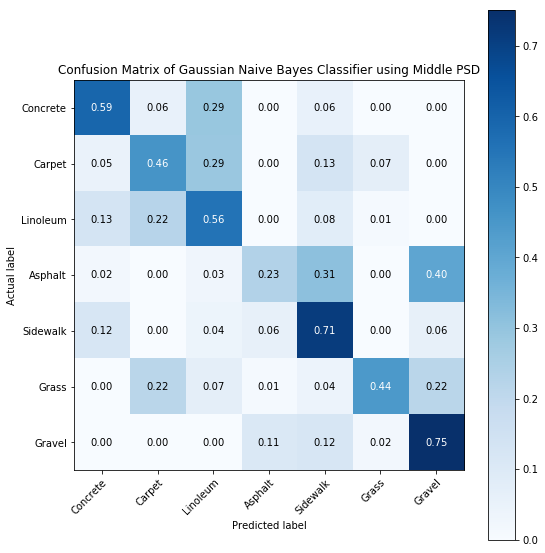

In [369]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Gaussian Naive Bayes Classifier using Middle PSD')

### Part (b) - SVM

In [371]:
from sklearn.svm import SVC
model = SVC()

In [372]:
# Predict for each of our feature vectors
predict_feat = predict_each_direction(train_feat, test_feat, model)
predict_fft = predict_each_direction(train_fft, test_fft, model)
predict_psd_log = predict_each_direction(train_psd_log, test_psd_log, model)

In [428]:
# Save as tuple of vectors
predict_vectors = (predict_feat, predict_fft, predict_psd_log)

In [389]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat[1]['Middle'], predict_feat['Middle'])
print('Middle Extracted Feat SVM Classifer: Accuracy = {}'.format(accuracy))

Middle Extracted Feat SVM Classifer: Accuracy = 0.45317220543806647


In [390]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft[1]['Left'], predict_fft['Left'])
print('Left FFT SVM Classifer: Accuracy = {}'.format(accuracy))

Left FFT SVM Classifer: Accuracy = 0.2264808362369338


In [391]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Right'], predict_psd_log['Right'])
print('Right PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Right PSD SVM Classifer: Accuracy = 0.8297101449275363


In [388]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Middle PSD SVM Classifer: Accuracy = 0.8640483383685801


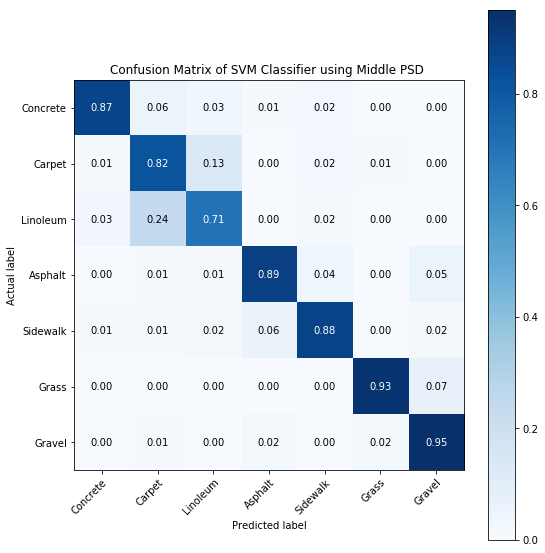

In [376]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier using Middle PSD ')

In [455]:
save_all_cm(test_vectors, predict_vectors, 'SVM')

#### Power Assist Dataset

In [396]:
# Extract train and test from each set of features
train_feat_power, test_feat_power = extract_train_test(feat_combined_power)
train_fft_power, test_fft_power = extract_train_test(fft_combined_power)
train_psd_log_power, test_psd_log_power = extract_train_test(psd_log_combined_power)

In [470]:
train_vectors_power = (train_feat_power, train_fft_power, train_psd_log_power)
test_vectors_power = (test_feat_power, test_fft_power, test_psd_log_power)

In [397]:
predict_feat_power = predict_each_direction(train_feat_power, test_feat_power, model)
predict_fft_power = predict_each_direction(train_fft_power, test_fft_power, model)
predict_psd_log_power = predict_each_direction(train_psd_log_power, test_psd_log_power, model)

In [471]:
predict_vectors_power = (train_feat_power, train_fft_power, train_psd_log_power)

In [ ]:
plot_confusion_matrix(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier using Middle PSD Power')

In [472]:
save_all_cm(test_vectors_power, predict_vectors_power, 'SVM', save_tag='Power')

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


#### Manual Dataset

In [401]:
# Extract train and test from each set of features
train_feat_manual, test_feat_manual = extract_train_test(feat_combined_manual)
train_fft_manual, test_fft_manual = extract_train_test(fft_combined_manual)
train_psd_log_manual, test_psd_log_manual = extract_train_test(psd_log_combined_manual)

In [461]:
train_vectors_manual = (train_feat_manual, train_fft_manual, train_psd_log_manual)
test_vectors_manual = (test_feat_manual, test_fft_manual, test_psd_log_manual)

In [402]:
predict_feat_manual = predict_each_direction(train_feat_manual, test_feat_manual, model)
predict_fft_manual = predict_each_direction(train_fft_manual, test_fft_manual, model)
predict_psd_log_manual = predict_each_direction(train_psd_log_manual, test_psd_log_manual, model)

In [459]:
predict_vectors_manual = (train_feat_power, train_fft_power, train_psd_log_power)

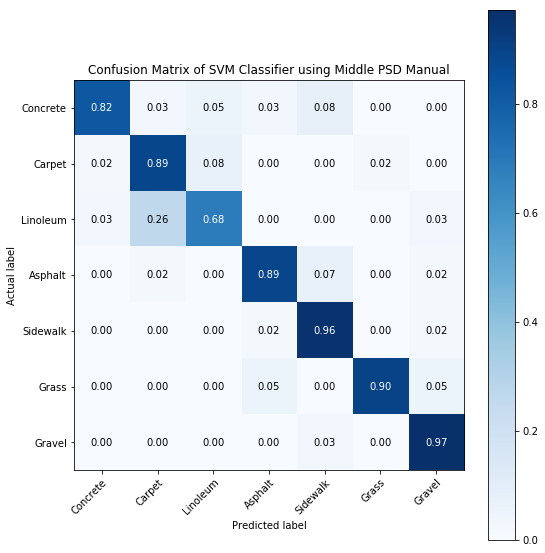

In [408]:
plot_confusion_matrix(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier using Middle PSD Manual')

In [469]:
save_all_cm(test_vectors_manual, predict_vectors_manual, 'SVM', save_tag='Manual')

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## Part 9 - Combining Feature Selection with Classifiers

In [551]:
def extract_top_features(combined_dataset, nfeats):
    combined_top_features = {}
    
    # Use mRMR to extract features from each placement
    for placement in placements:
        if placement in combined_dataset.keys():
            top_feats = pymrmr.mRMR(data=combined_dataset[placement], method='MID', nfeats=nfeats)
            # Always add label
            top_feats.append('Label')
            
        combined_top_features.update({placement: top_feats})
    
    return combined_top_features

In [518]:
def top_features_only(combined, top_features):
    combined_top = {}
    
    for placement in placements:
        combined_top.update({placement: combined[placement].loc[:, top_features[placement]]})
        
    return combined_top

### Part (a) - Feature Selection

#### Part (i) - Extracted Features

In [516]:
feat_top_features = extract_top_features(feat_combined, 40)

In [519]:
feat_combined_top = top_features_only(feat_combined, feat_top_features)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_direction(train_feat_top, test_feat_top, model)

In [536]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Middle'], predict_feat_top['Middle'])
print('Middle SVM Classifer with Top 40 Extracted Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 40 Extracted Features: Accuracy = 0.39274924471299094


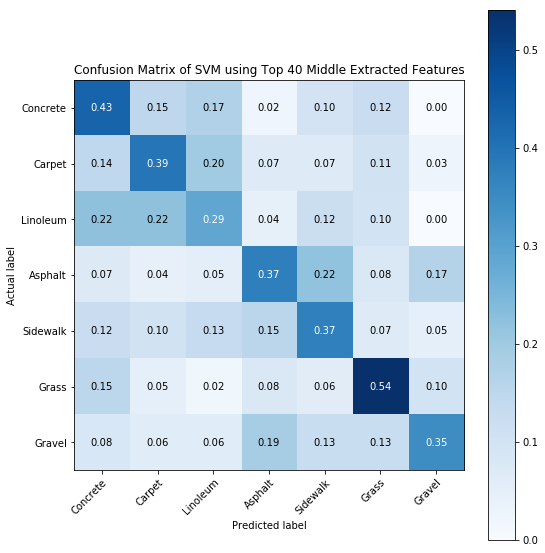

In [523]:
plot_confusion_matrix(test_feat_top[1]['Middle'], predict_feat_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 40 Middle Extracted Features')

#### Part (ii) - FFT

In [538]:
fft_top_features = extract_top_features(fft_combined, 40)

In [539]:
fft_combined_top = top_features_only(fft_combined, fft_top_features)
train_fft_top, test_fft_top = extract_train_test(fft_combined_top)
predict_fft_top = predict_each_direction(train_fft_top, test_fft_top, model)

In [541]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft_top[1]['Middle'], predict_fft_top['Middle'])
print('Middle SVM Classifer with Top 40 FFT Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 40 FFT Features: Accuracy = 0.5664652567975831


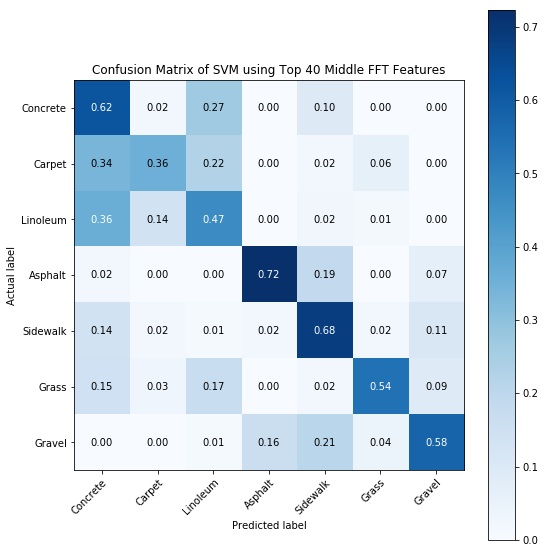

In [542]:
plot_confusion_matrix(test_fft_top[1]['Middle'], predict_fft_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 40 Middle FFT Features')

#### Part (iii) - FFT

In [544]:
psd_log_top_features = extract_top_features(psd_log_combined, 40)

In [547]:
psd_log_combined_top = top_features_only(psd_log_combined, psd_log_top_features)
train_psd_log_top, test_psd_log_top = extract_train_test(psd_log_combined_top)
predict_psd_log_top = predict_each_direction(train_psd_log_top, test_psd_log_top, model)

In [548]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'])
print('Middle SVM Classifer with Top 40 PSD Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 40 PSD Features: Accuracy = 0.7099697885196374


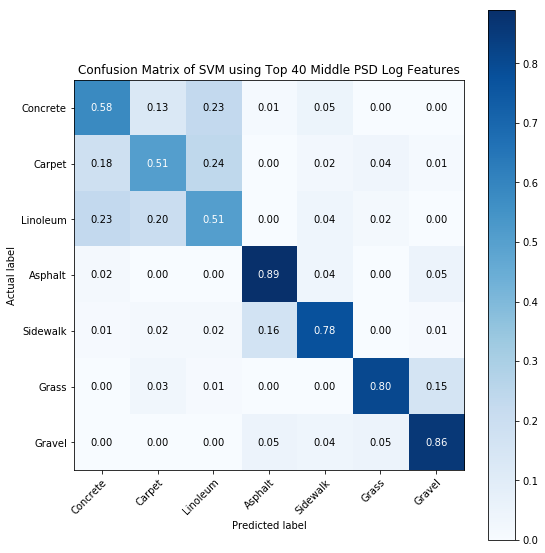

In [549]:
plot_confusion_matrix(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 40 Middle PSD Log Features')

#### Compute mRMR up to maximum number of features

In [ ]:
feat_top_features = extract_top_features(feat_combined, 90)

In [ ]:
pd.Series(feat_top_features).to_csv('processed_data/mRMR/Features.csv')

In [ ]:
fft_top_features = extract_top_features(fft_combined, 600)

In [ ]:
psd_log_top_features = extract_top_features(psd_log_combined, 600)

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right